# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Необходимо построить модель, которая умеет её определять. Предоставлены данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

## Подготовка данных

### Импорт модулей

In [1]:
%%capture

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

!pip install phik;
from phik import phik_matrix

!pip3 install --upgrade scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

!pip3 install catboost
from catboost import CatBoostRegressor

import lightgbm as lgb

import time

import os

### Загрузка датасета и общая информация

In [2]:
# чтение файла с данными и сохранение в df
try:
    path = '/datasets/autos.csv'
    df = pd.read_csv(path)

except FileNotFoundError:
    current_directory = os.getcwd()
    df = pd.read_csv(current_directory + path)

display(df.head())
display(df.describe())
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

### Удаление полных дубликатов

In [3]:
df = df.drop_duplicates()

## Статистический анализ данных

### Визуализация распределений данных

Price анализ


count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

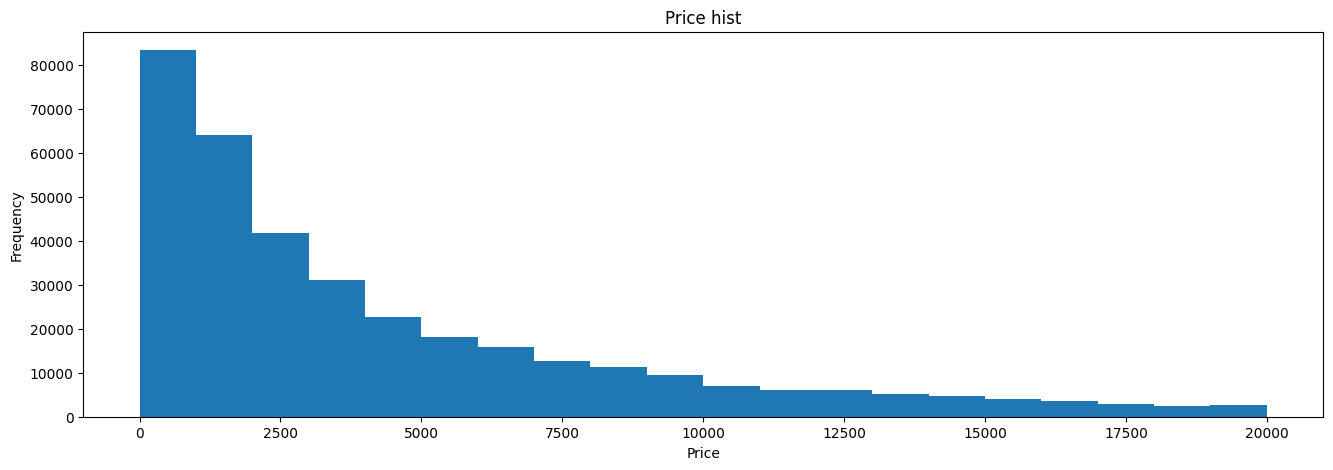

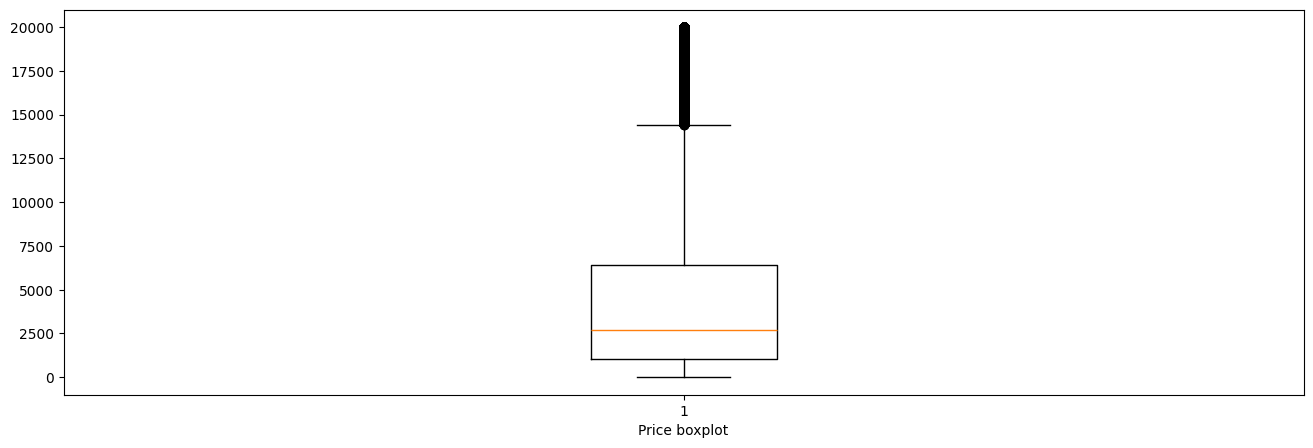

RegistrationYear анализ


count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

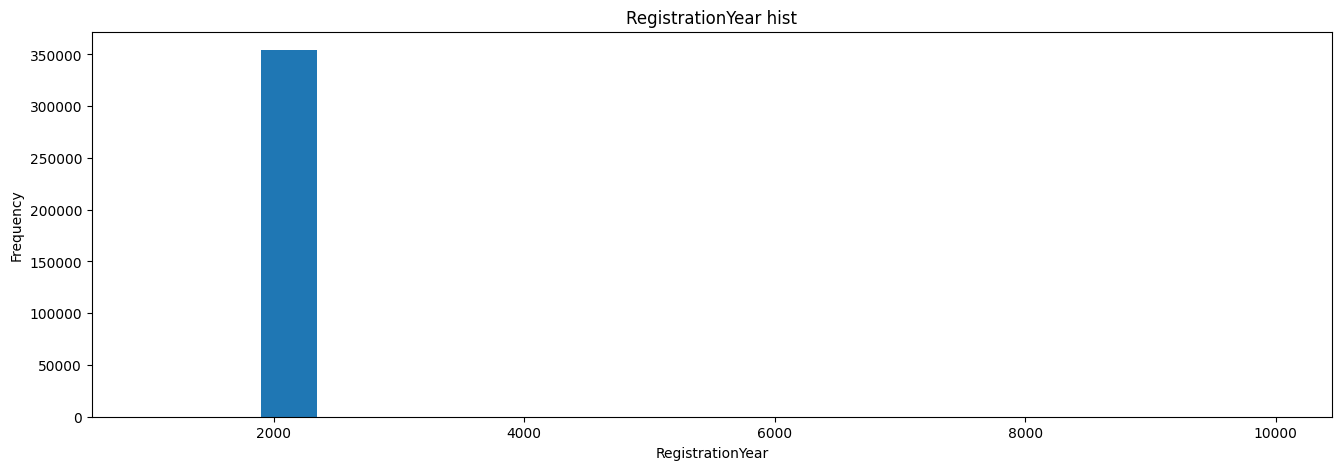

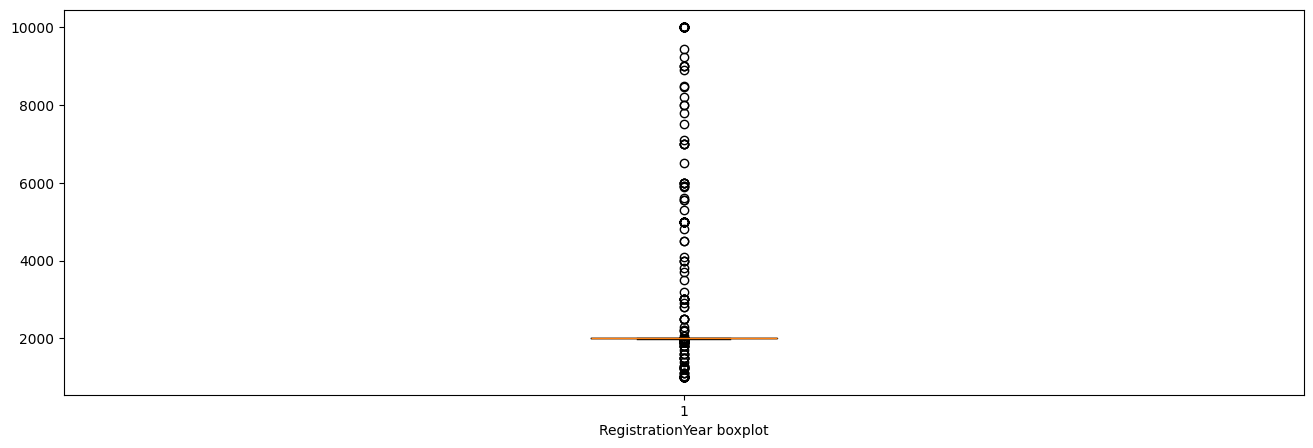

Power анализ


count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

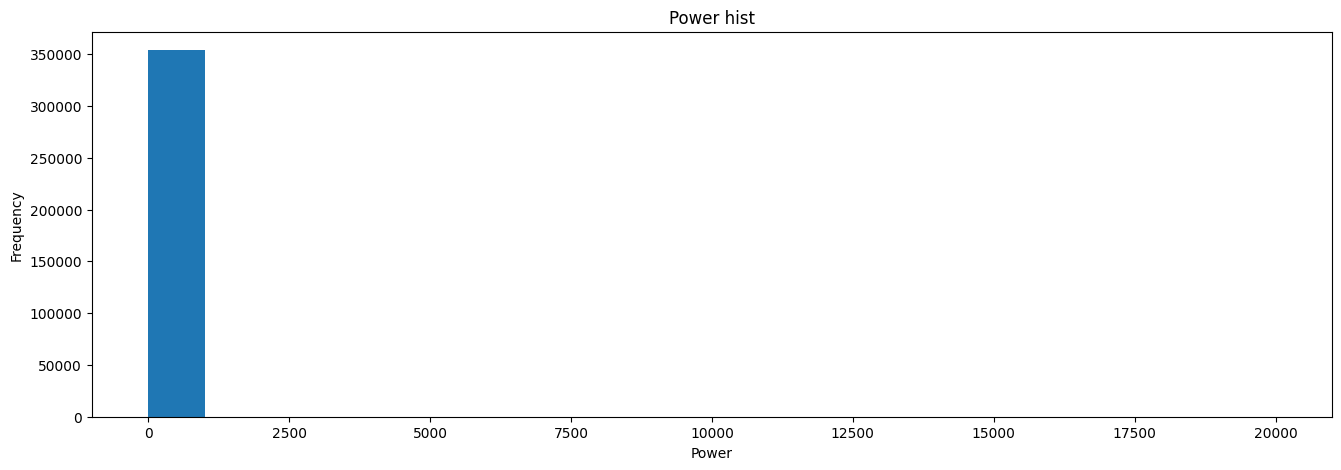

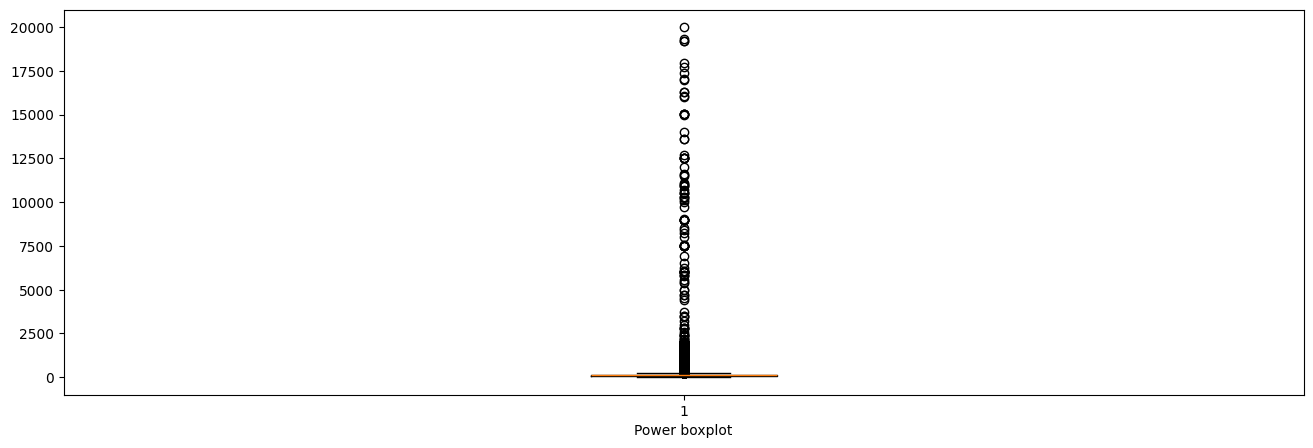

Kilometer анализ


count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

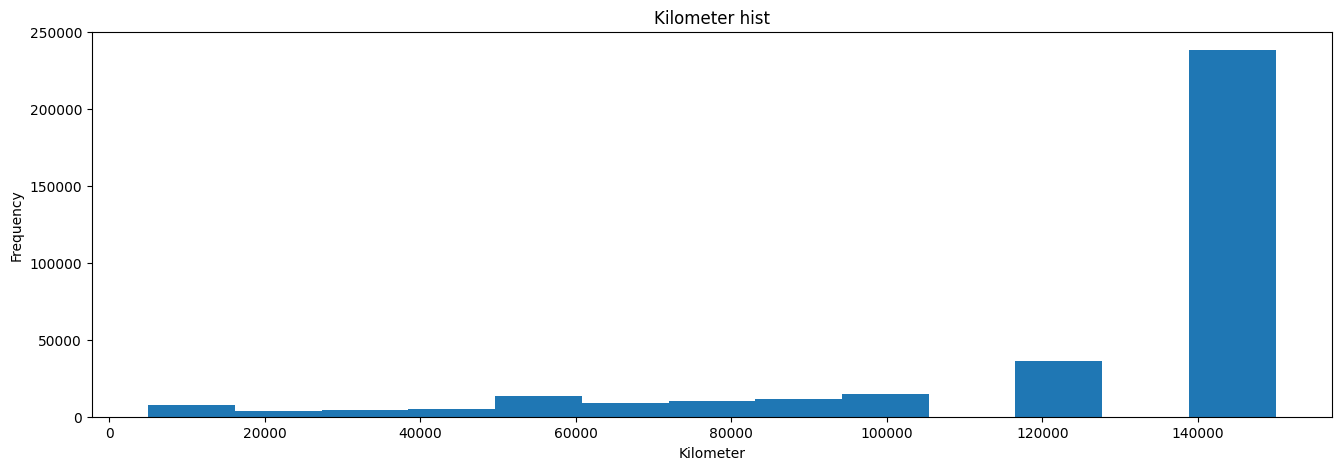

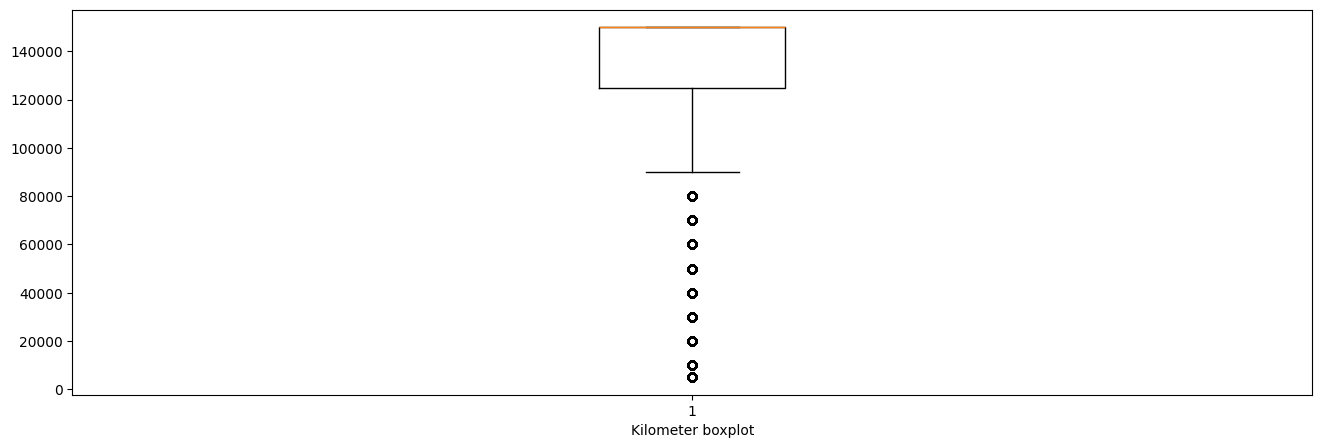

RegistrationMonth анализ


count    354365.000000
mean          5.714650
std           3.726432
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

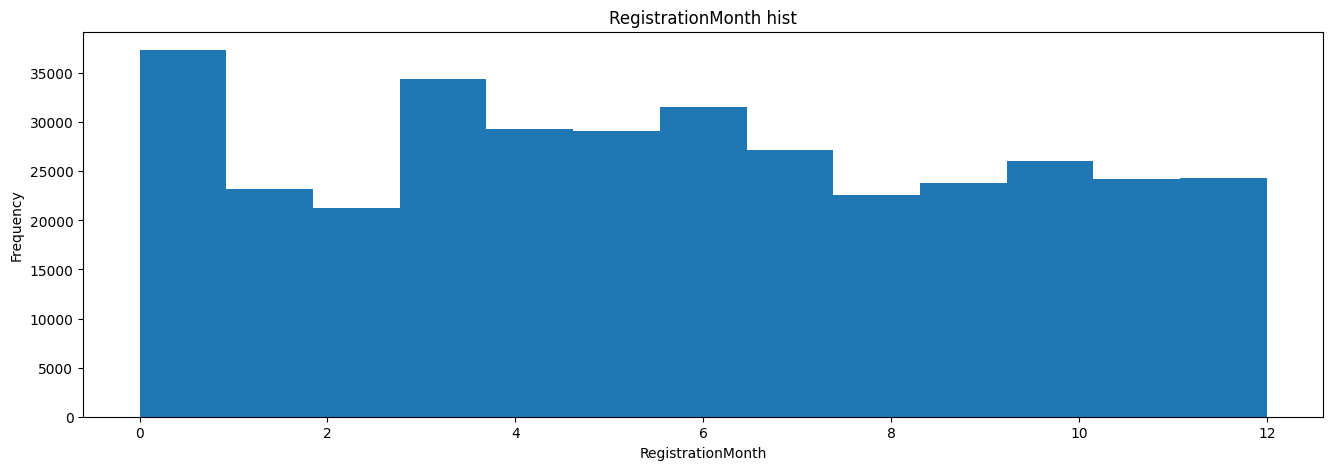

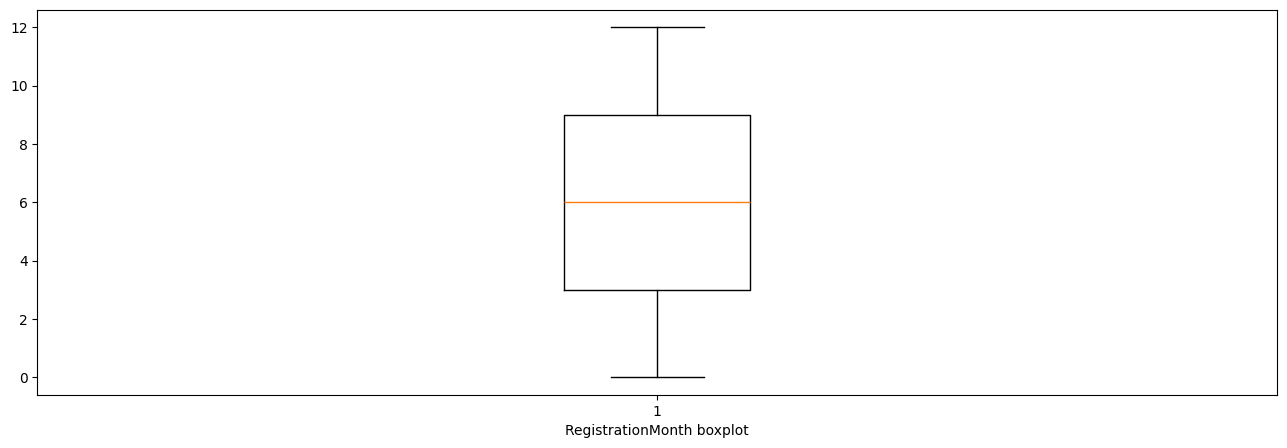

NumberOfPictures анализ


count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

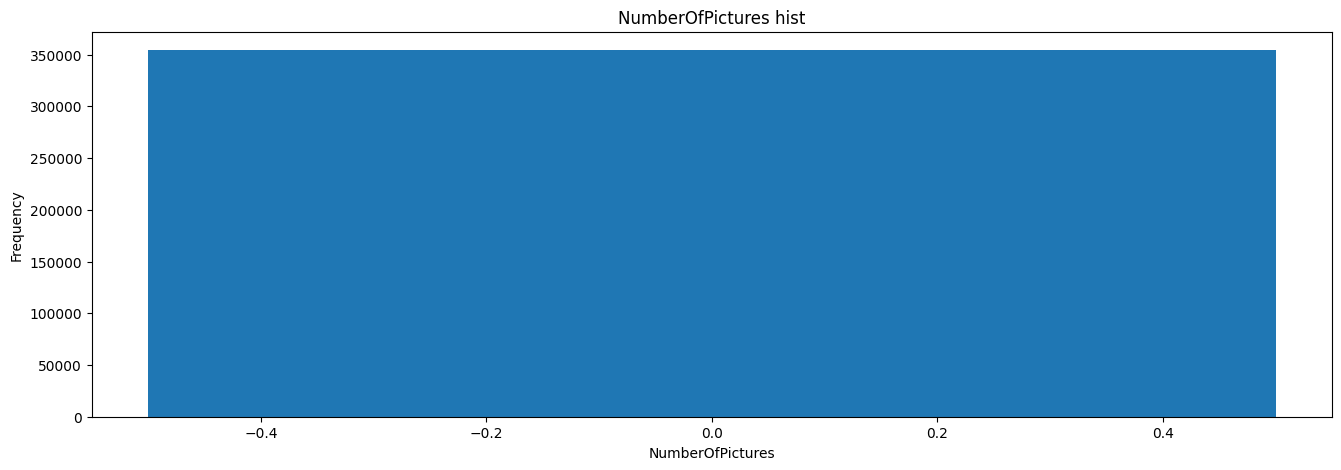

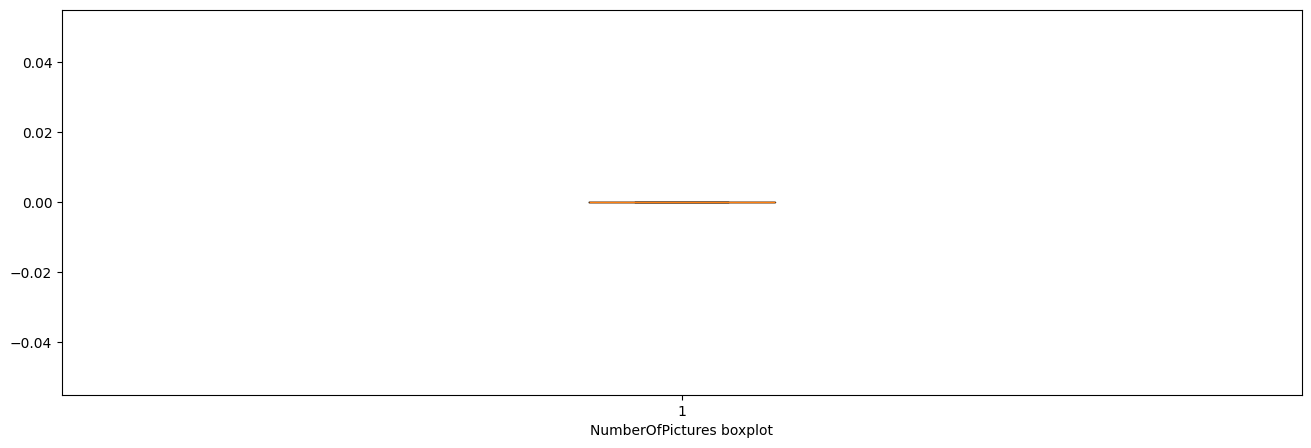

PostalCode анализ


count    354365.000000
mean      50508.503800
std       25783.100078
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64

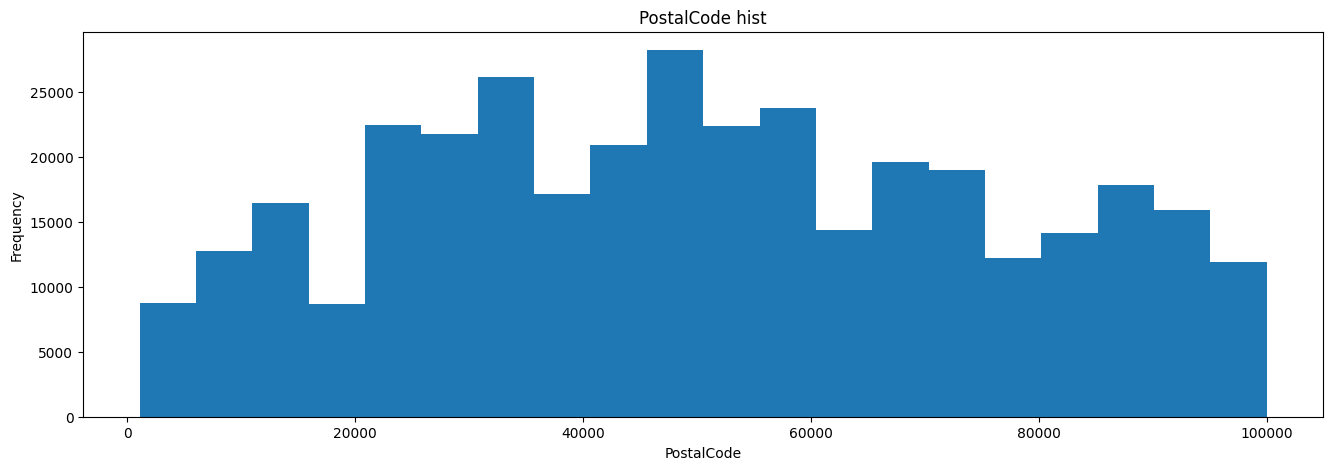

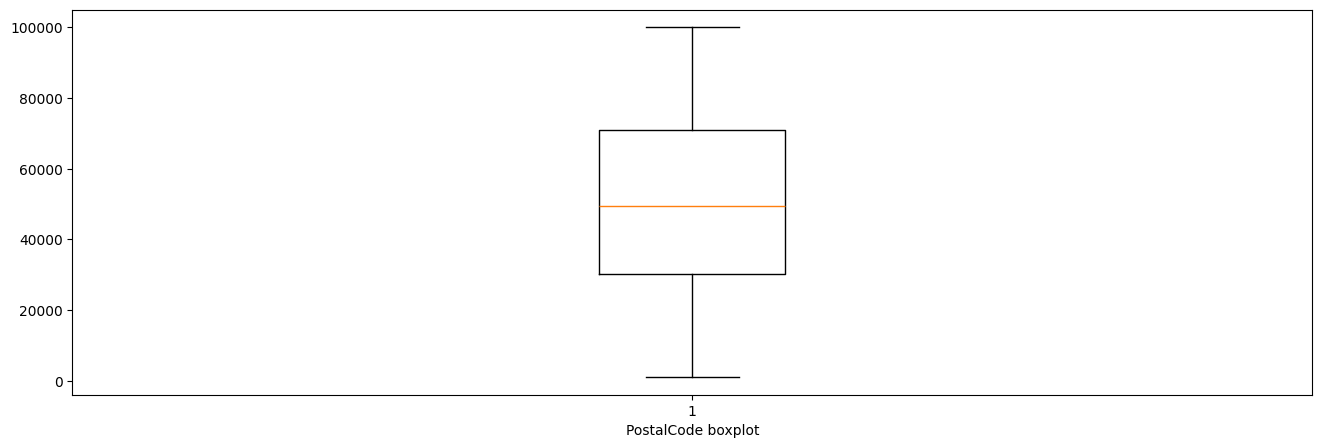

In [4]:
# Функция построения гистограмм и boxplot для численных данных

def histplotter(df):
    df = df.copy()
    for column in df.select_dtypes(exclude=[object]).columns:
        print(column, 'анализ')
        display(df[column].describe())
        plt.figure(figsize=(16, 5))
        plt.hist(df[column], align='mid', bins = np.min([len(df[column].unique()), 20]))
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(str(column + ' hist'))
        plt.show()
        print()
        plt.figure(figsize=(16, 5))
        plt.boxplot(df[column])
        plt.xlabel(str(column + ' boxplot'))
        plt.show()
    return

histplotter(df)

VehicleType анализ


count     316875
unique         8
top        sedan
freq       91457
Name: VehicleType, dtype: object


VehicleType unique values: ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon', nan]



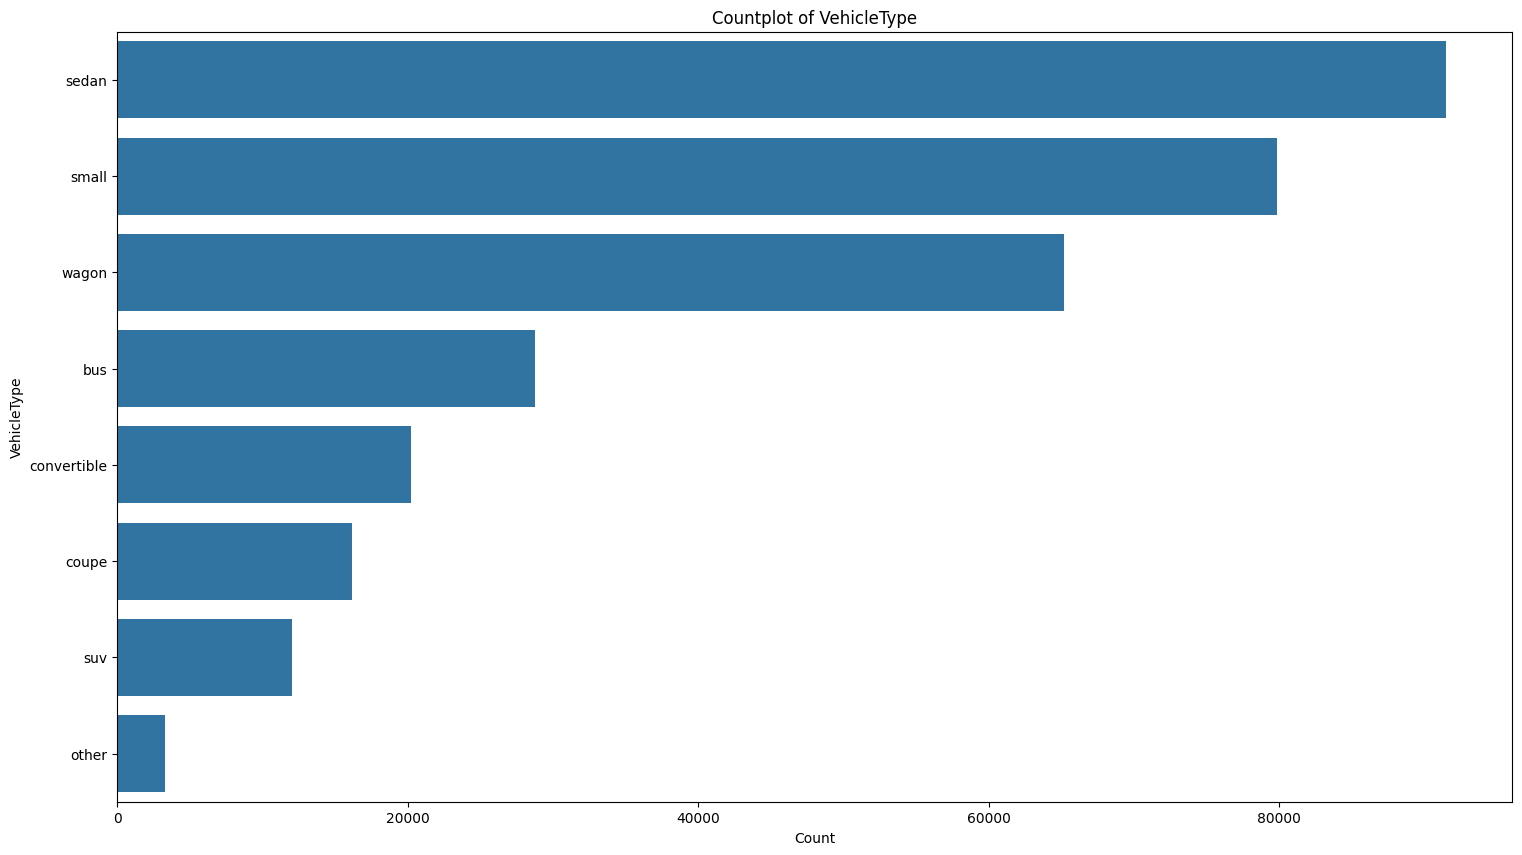

Gearbox анализ


count     334532
unique         2
top       manual
freq      268249
Name: Gearbox, dtype: object


Gearbox unique values: ['auto', 'manual', nan]



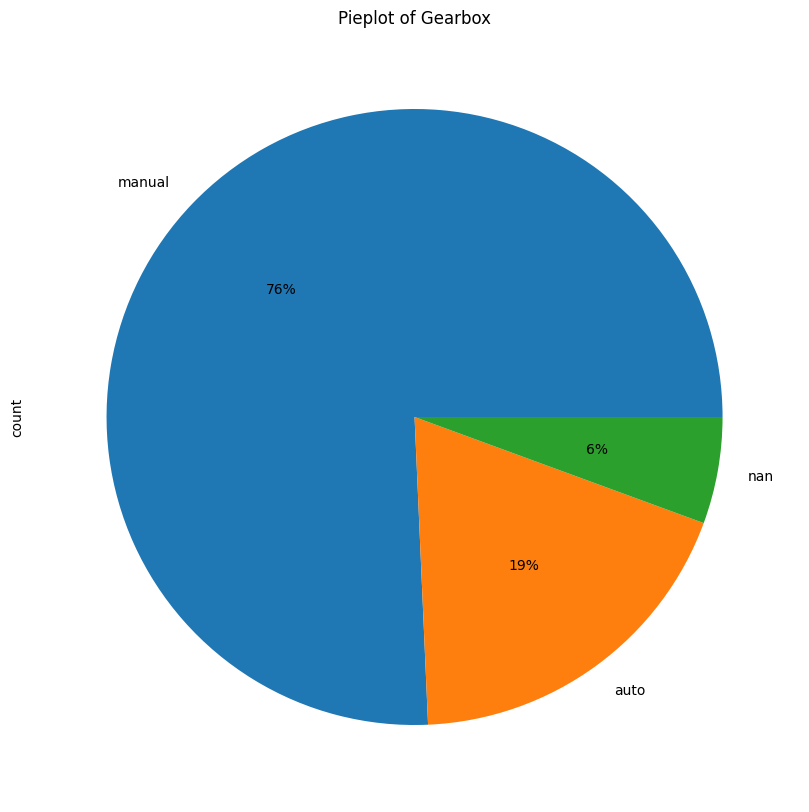

Model анализ


count     334660
unique       250
top         golf
freq       29232
Name: Model, dtype: object


Model unique values: ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fox', 'f

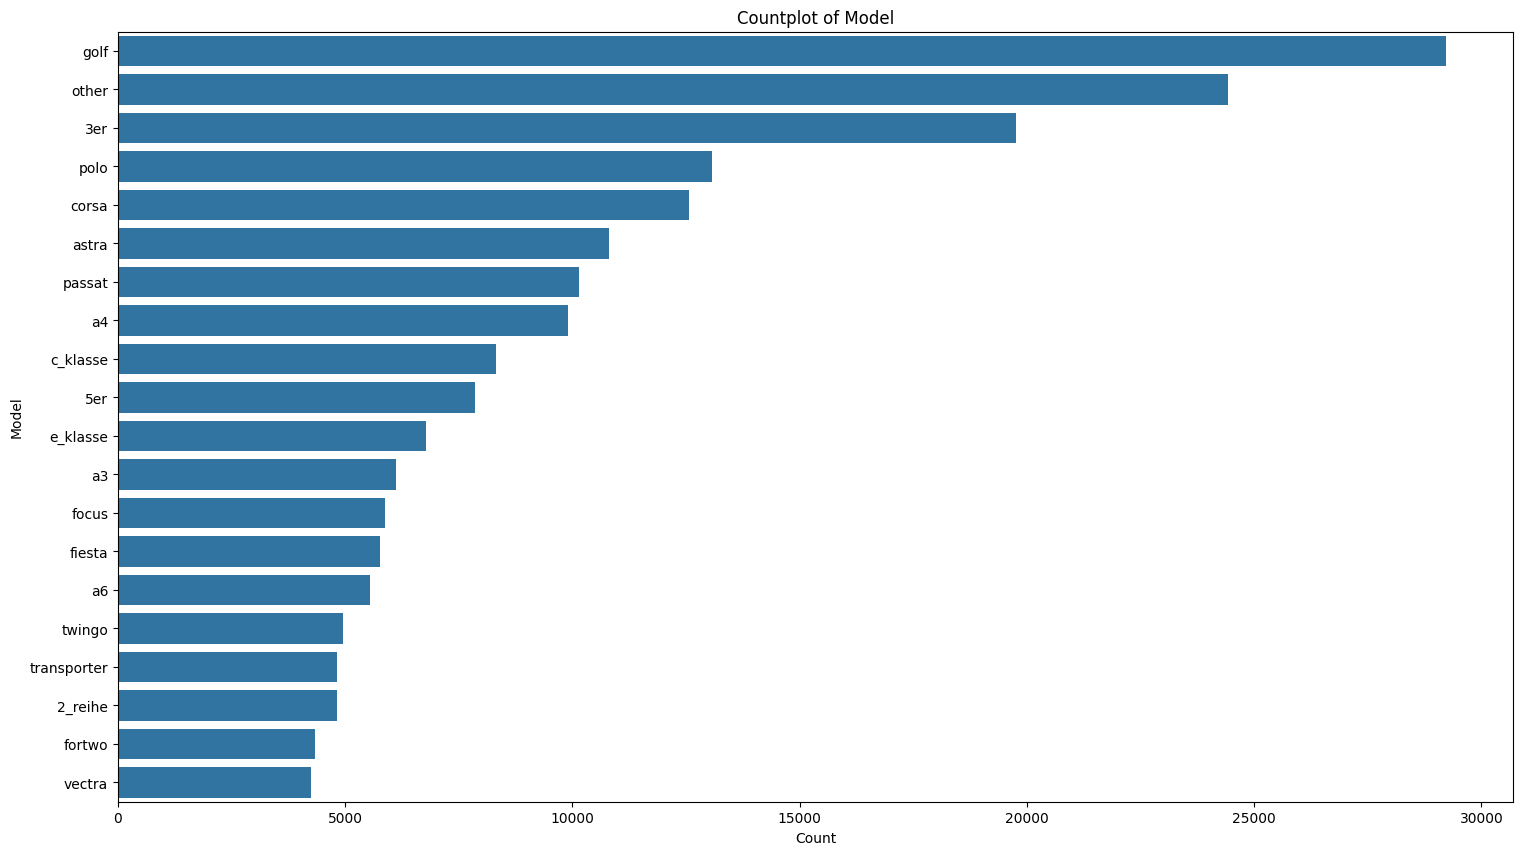

FuelType анализ


count     321470
unique         7
top       petrol
freq      216349
Name: FuelType, dtype: object


FuelType unique values: ['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol', nan]



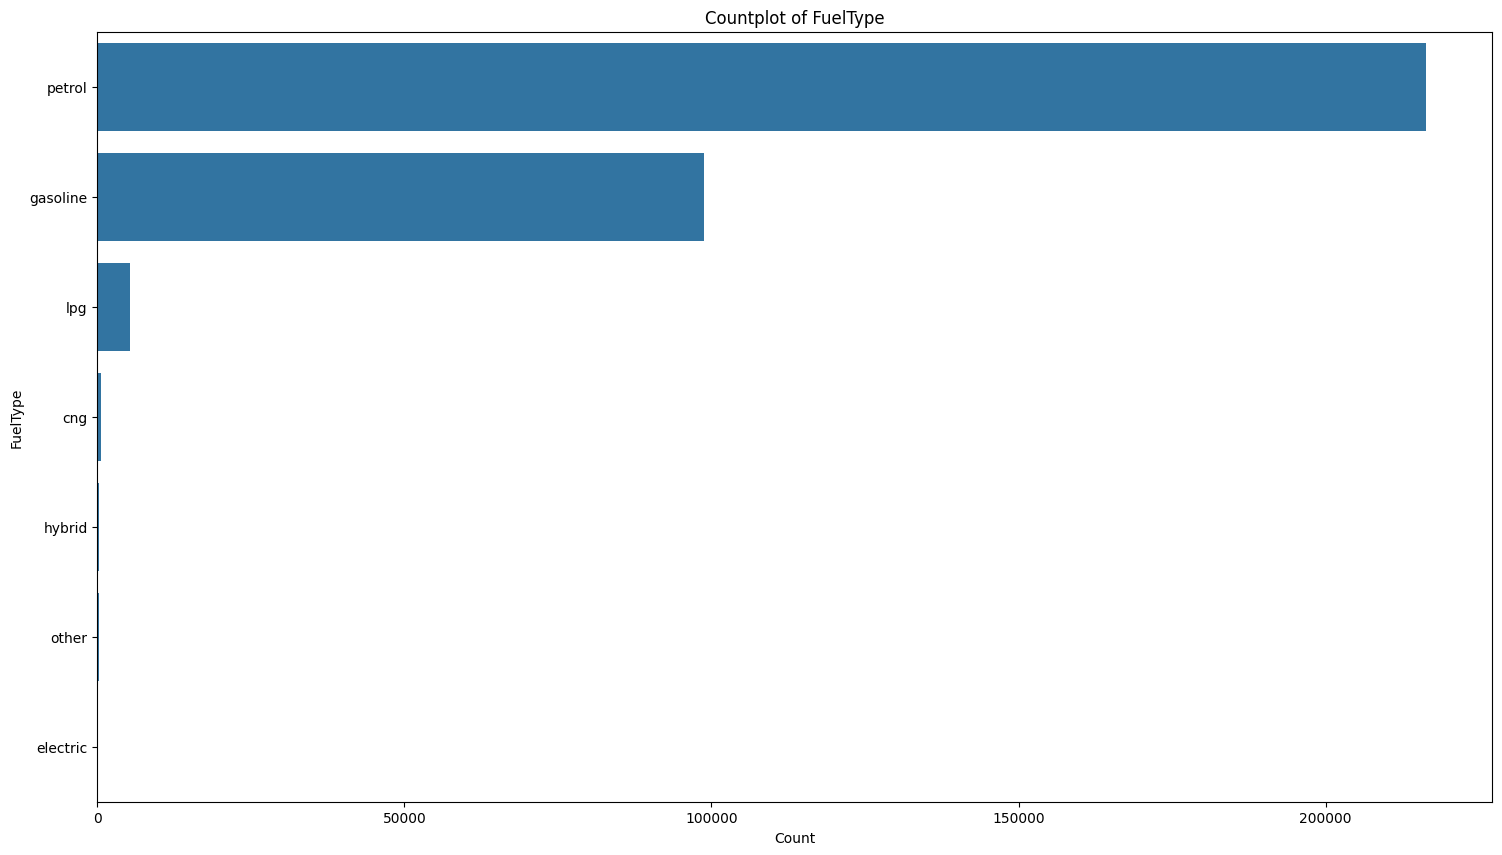

Brand анализ


count         354365
unique            40
top       volkswagen
freq           77012
Name: Brand, dtype: object


Brand unique values: ['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']



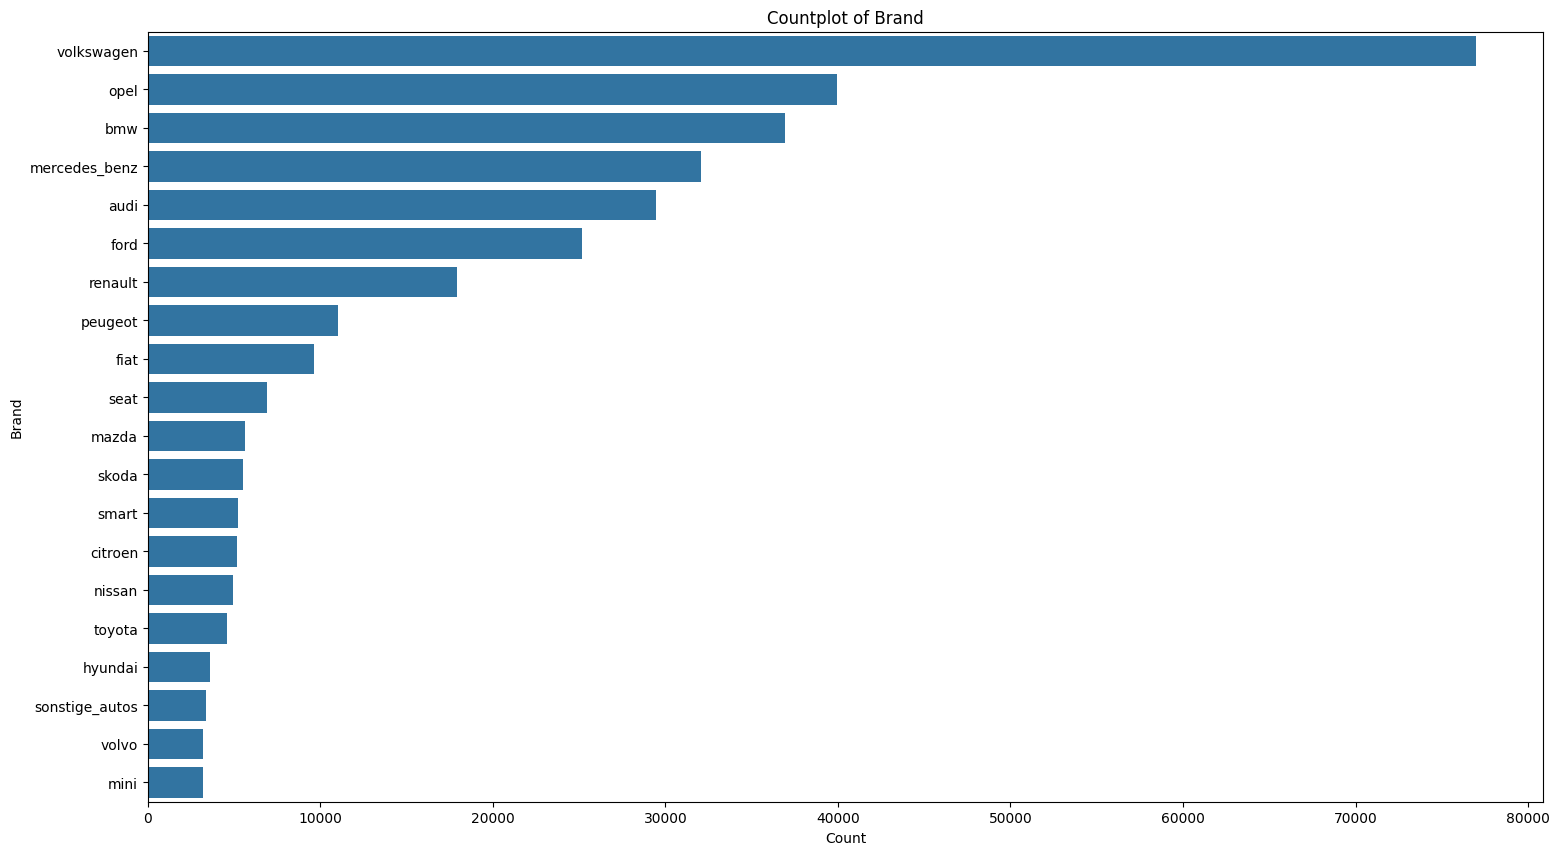

Repaired анализ


count     283211
unique         2
top           no
freq      247158
Name: Repaired, dtype: object


Repaired unique values: ['no', 'yes', nan]



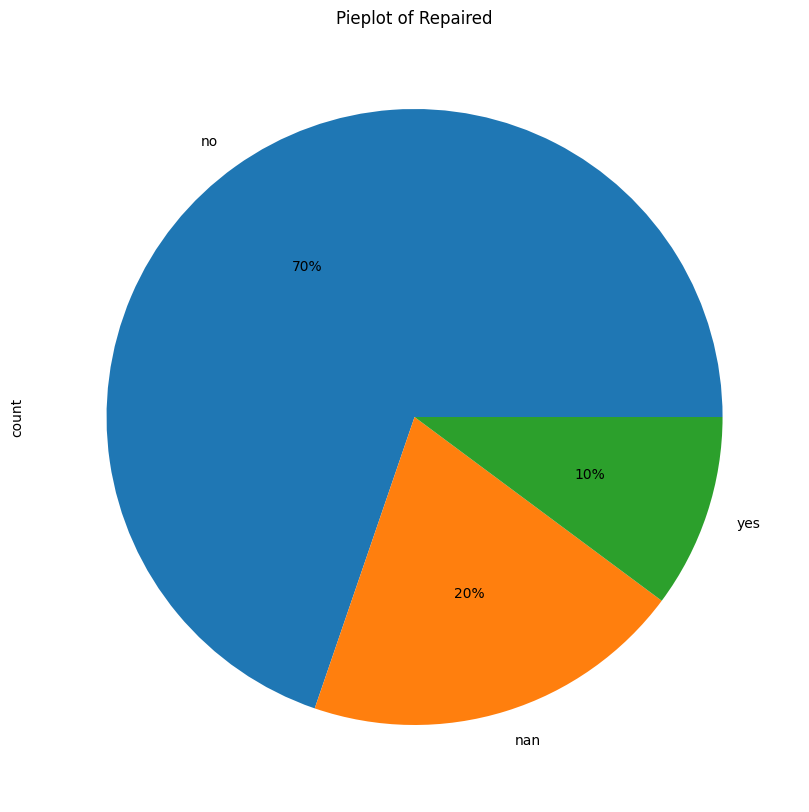

In [5]:
# Функция построения pie диаграмм для нечисленных данных

def barplotter(df):
    df = df.copy()
    for column in df.select_dtypes(include=[object]).columns:
        print(column, 'анализ')
        display(df[column].describe())
        print()
        unique_values_sorted = df[column].drop_duplicates().sort_values().tolist()
        print(column, 'unique values:', unique_values_sorted)
        print()
        if len(df[column].unique())>6:
            top_n = 20
            top_categories = df[column].value_counts().nlargest(top_n).index.tolist()
            filtered_df = df[df[column].isin(top_categories)]
            plt.figure(figsize=(18, 10))
            sns.countplot(y=column, data=filtered_df, order=filtered_df[column].value_counts().index)
            plt.xlabel('Count')
            plt.title(str('Countplot of ' + column))
            plt.show()
        else:
            plt.figure(figsize=(18, 10))
            df[column].value_counts(dropna=False).plot(kind="pie", autopct='%1.0f%%')
            plt.title(str('Pieplot of ' + column))
            plt.show()
    return

barplotter(df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis = 1))

In [6]:
# Анализ столбцов с временными данными

print('DateCreated')
display(df['DateCreated'].sort_values())
print('DateCrawled')
display(df['DateCrawled'].sort_values())
print('LastSeen')
display(df['LastSeen'].sort_values())

DateCreated


61207     2014-03-10 00:00:00
4001      2015-03-20 00:00:00
342275    2015-06-18 00:00:00
86601     2015-08-07 00:00:00
175103    2015-08-10 00:00:00
                 ...         
184411    2016-04-07 00:00:00
262340    2016-04-07 00:00:00
214462    2016-04-07 00:00:00
241969    2016-04-07 00:00:00
260600    2016-04-07 00:00:00
Name: DateCreated, Length: 354365, dtype: object

DateCrawled


329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
176823    2016-03-05 14:06:24
324763    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, Length: 354365, dtype: object

LastSeen


296785    2016-03-05 14:15:08
262341    2016-03-05 14:15:16
130462    2016-03-05 14:15:39
285695    2016-03-05 14:18:30
169065    2016-03-05 14:25:59
                 ...         
59506     2016-04-07 14:58:50
290312    2016-04-07 14:58:50
245598    2016-04-07 14:58:50
68870     2016-04-07 14:58:50
327303    2016-04-07 14:58:51
Name: LastSeen, Length: 354365, dtype: object

In [7]:
# Анализируем столбец FuelType

df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

В столбце FuelType замечена ошибка, т.к. petrol и gasoline - имеют одно и то же значение, но используются в разных традициях. Приводим все к petrol.

In [8]:
# Анализируем столбец Model

df.loc[df['Model'] == 'rangerover', 'Model'] = 'range_rover'

В столбце Model замечен и исправлен неполный дубликат.

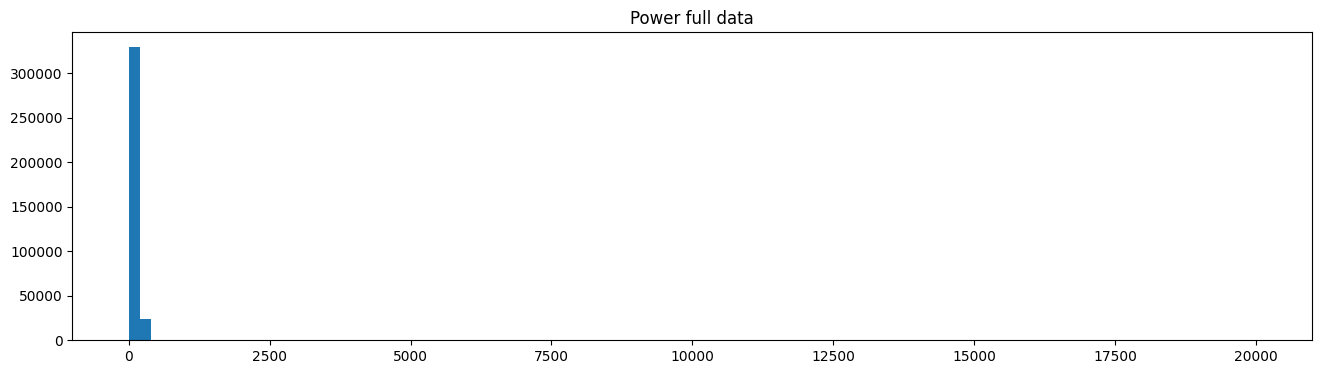

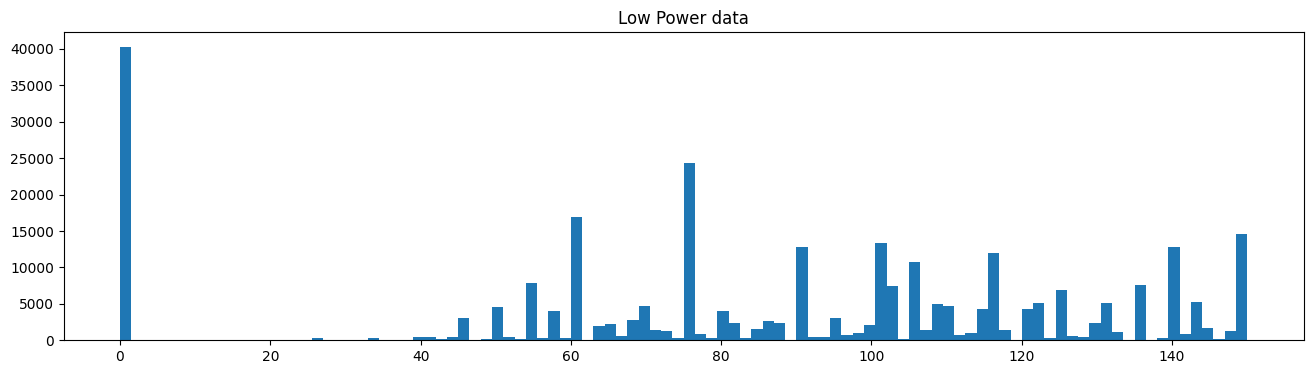

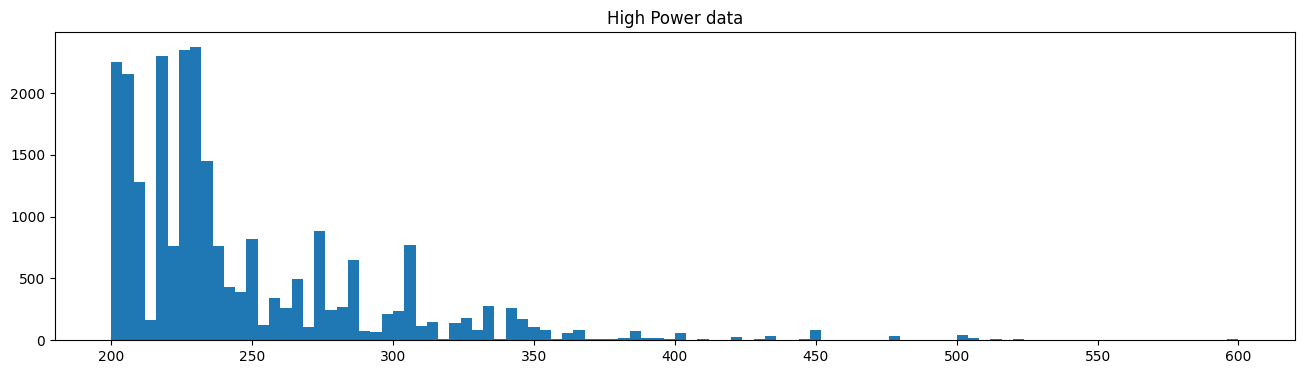

In [9]:
# Анализируем столбец Power

plt.figure(figsize = (16,4))
plt.hist(df['Power'], bins=100)
plt.title('Power full data')
plt.show()

plt.figure(figsize = (16,4))
plt.hist(df['Power'], bins=100, range=(0, 150))
plt.title('Low Power data')
plt.show()

plt.figure(figsize = (16,4))
plt.hist(df['Power'], bins=100, range=(200, 600))
plt.title('High Power data')
plt.show()

In [10]:
# Удаляем строчки с Power менее 30 и более 550

df = df[df['Power'] > 30]
df = df[df['Power'] < 550]

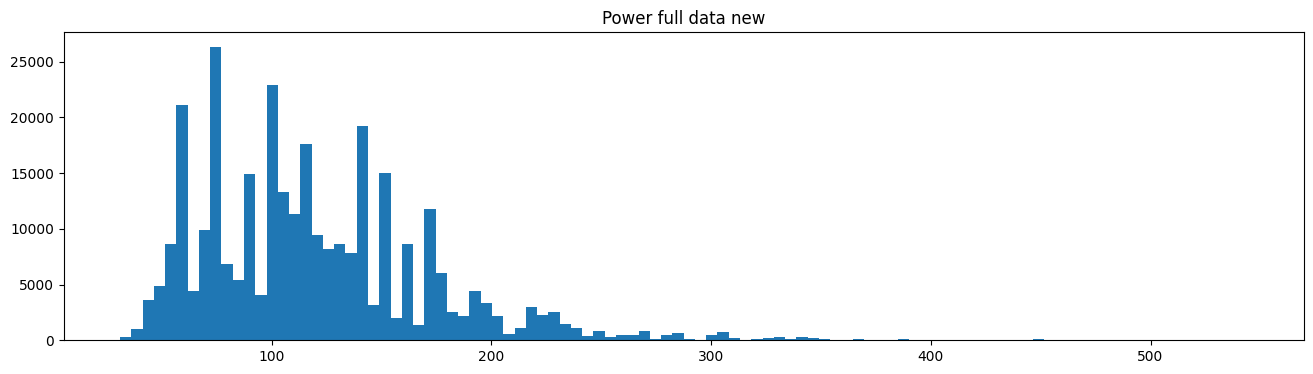

In [11]:
plt.figure(figsize = (16,4))
plt.hist(df['Power'], bins=100)
plt.title('Power full data new')
plt.show()

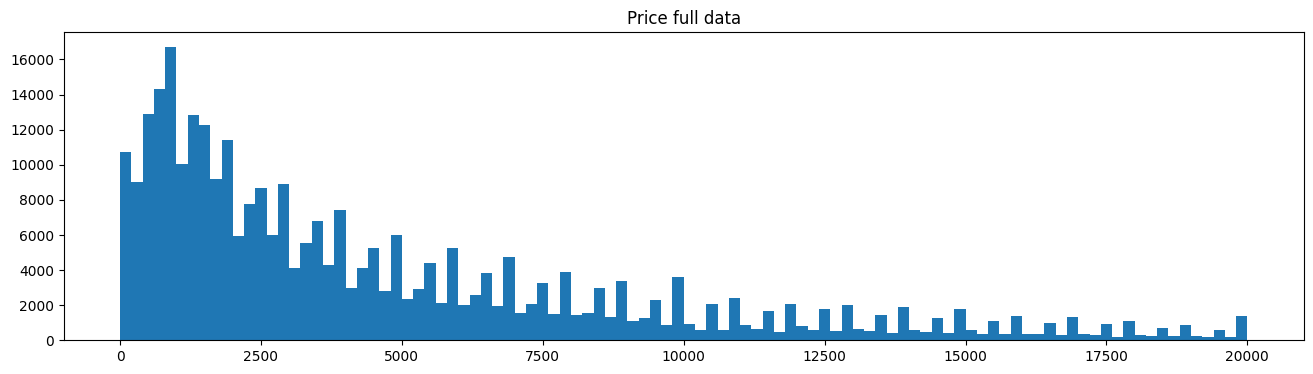

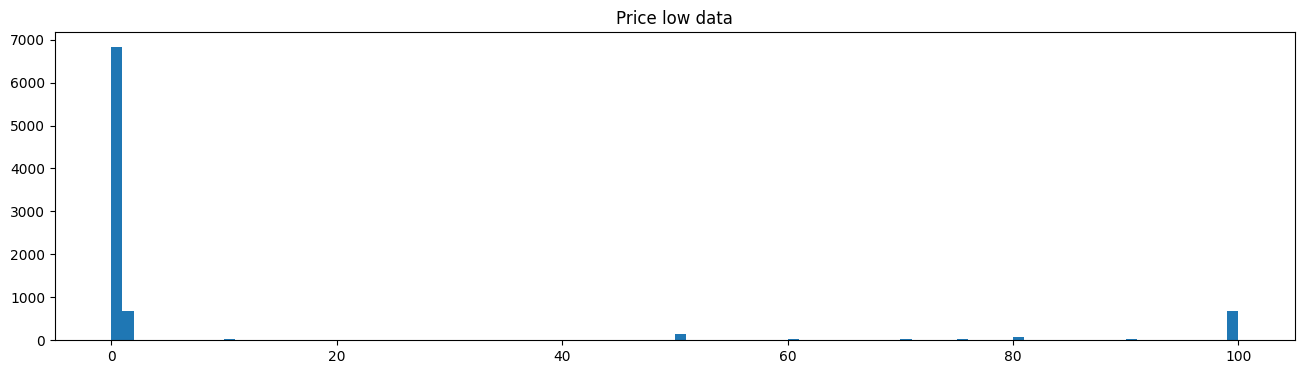

In [12]:
# Анализируем столбец Price

plt.figure(figsize = (16,4))
plt.hist(df['Price'], bins=100, range=(0,20000))
plt.title('Price full data')
plt.show()

plt.figure(figsize = (16,4))
plt.hist(df['Price'], bins=100, range=(0,100))
plt.title('Price low data')
plt.show()

In [13]:
# Удаляем строчки с Price не более 2

df = df[df['Price'] > 1000]

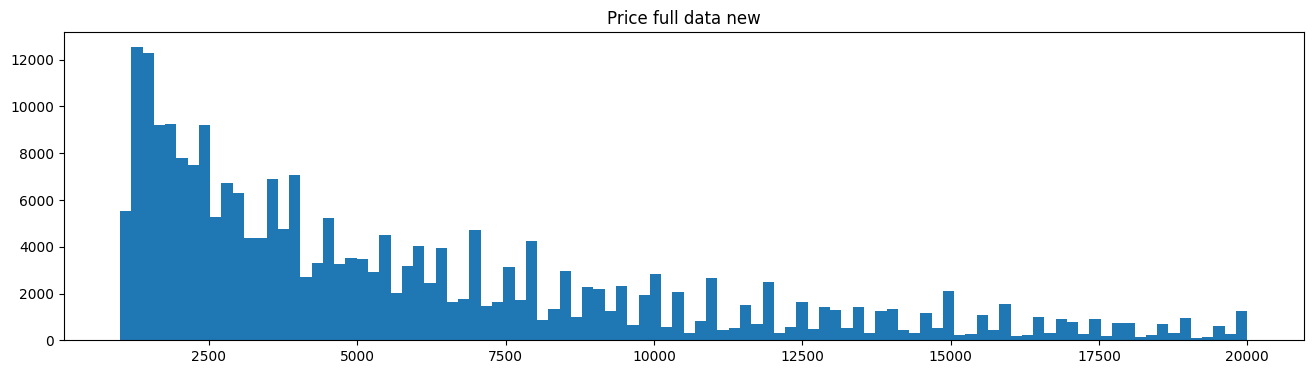

In [14]:
plt.figure(figsize = (16,4))
plt.hist(df['Price'], bins=100)
plt.title('Price full data new')
plt.show()

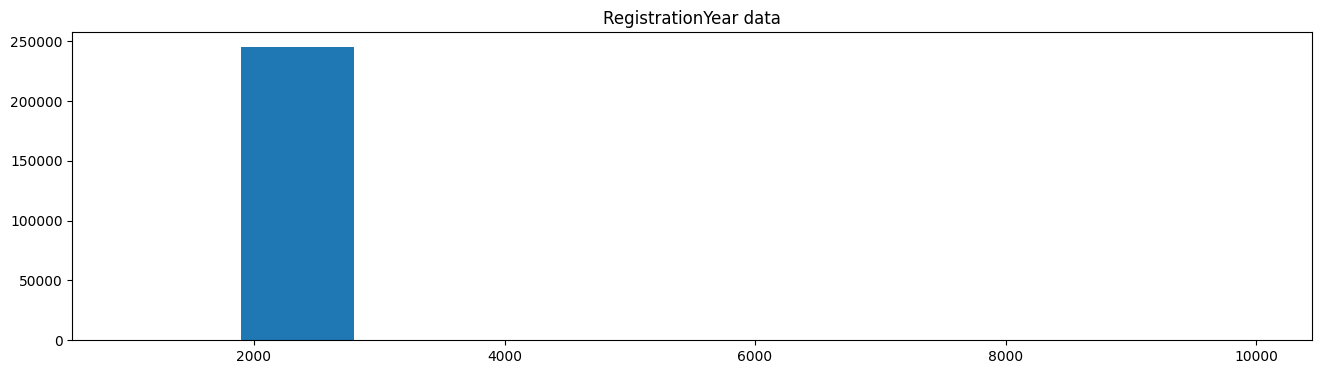

In [15]:
# Анализируем RegistrationYear

plt.figure(figsize = (16,4))
plt.hist(df['RegistrationYear'])
plt.title('RegistrationYear data')
plt.show()



In [16]:
# Удаляем все строчки с годом регистрации менее 1930 и более даты создания объявления, поскольку они являются ошибкой

df = df[df['RegistrationYear'] > 1930]
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['DateCreated'] = df['DateCreated'].dt.year.astype(int)
df = df[df['RegistrationYear'] <= df['DateCreated']]

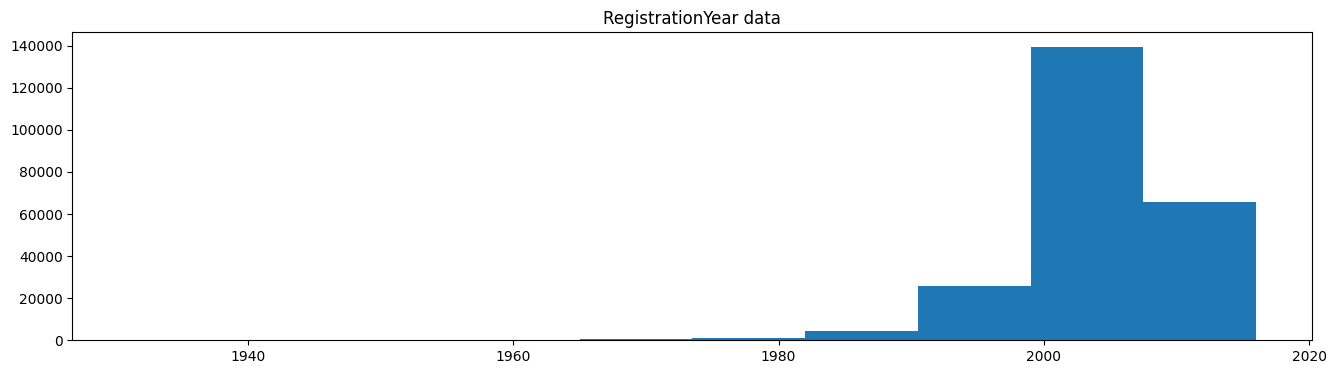

In [17]:
plt.figure(figsize = (16,4))
plt.hist(df['RegistrationYear'])
plt.title('RegistrationYear data')
plt.show()

In [18]:
# Удаляем неинформативные столбцы

df = df.drop(['LastSeen', 'DateCrawled', 'DateCreated', 'PostalCode', 'NumberOfPictures', 'RegistrationMonth'], axis = 1)

# Удаляем полные дубликаты после удаления лишних столбцов

df = df.drop_duplicates()

### Промежуточные выводы
Руководствуясь здравым смыслом, убираем из рассмотрения следующие столбцы:
- Registration month - столбец содержит значительное количество неверных данных (13 значений вместо 12 месяцев), а также не может оказывать большого влияния на цену автомобиля, в отличие от года регистрации.
- PostalCode - почтовый индекс не влияет на стоимость автомобиля.
- NumberOfPictures - все поля имеют одинаковое значение, не представляет ценности для обучения.
- Столбцы с датами - даты лежат в узком диапазоне и не могут оказывать большого влияния на цену, в отличие от года регистрации автомобиля.

### Обработка пропусков

In [19]:
# Посмотрим общую информацию об обновленном датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206115 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             206115 non-null  int64 
 1   VehicleType       200555 non-null  object
 2   RegistrationYear  206115 non-null  int64 
 3   Gearbox           202866 non-null  object
 4   Power             206115 non-null  int64 
 5   Model             199099 non-null  object
 6   Kilometer         206115 non-null  int64 
 7   FuelType          197308 non-null  object
 8   Brand             206115 non-null  object
 9   Repaired          180239 non-null  object
dtypes: int64(4), object(6)
memory usage: 17.3+ MB


In [20]:
print('Nan percent:', len(df.loc[df.isna().any(axis=1)])/len(df)*100, '%')

Nan percent: 18.756034252722994 %


Строчки с пропусками составляют менее 20% датасета, тем не менее, решено их не удалять, а заполнить "заглушками".  

In [21]:
df = df.fillna('Unknown')

### Корреляционный анализ

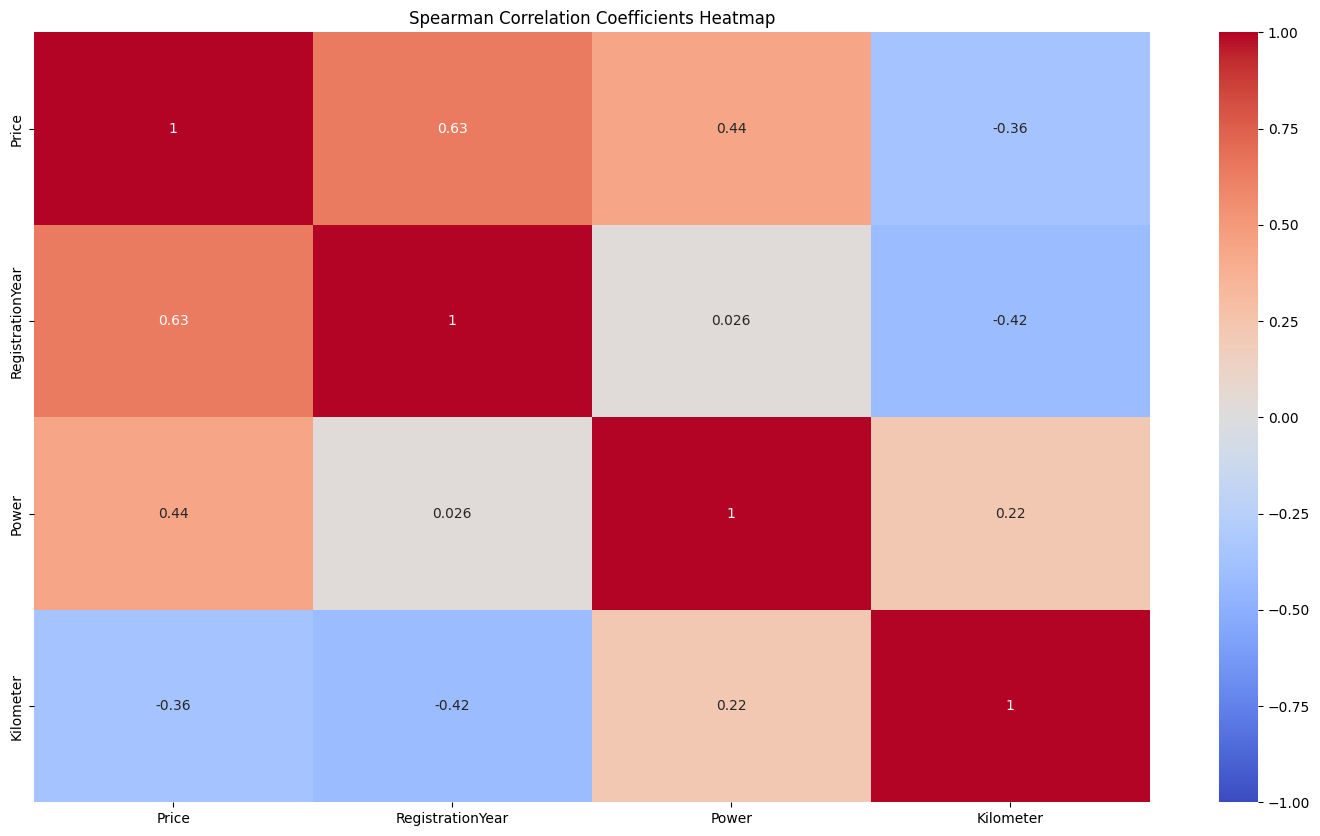

In [22]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr('spearman'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Coefficients Heatmap')
plt.show()

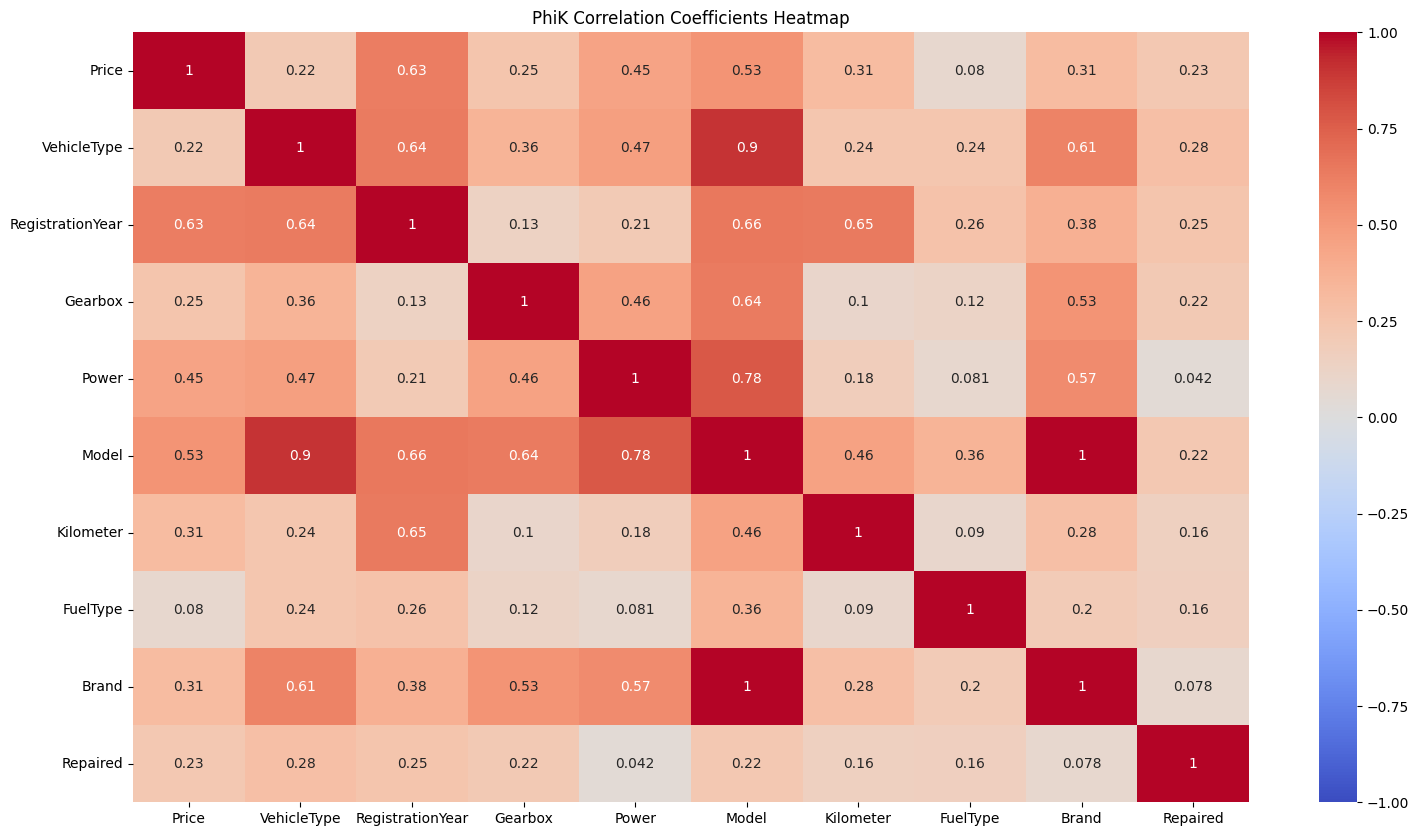

In [23]:
# Выбираем интересующие нас числовые признаки

interval_cols = ['Power', 'Price']

# Вычисляем матрицу корреляции с использованием phik

phik_corr_matrix = phik_matrix(df, interval_cols=interval_cols)

plt.figure(figsize=(18, 10))
sns.heatmap(phik_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('PhiK Correlation Coefficients Heatmap')
plt.show();

Была выявлена высокая корреляция между Model, VehicleType и Brand. Решено было удалить Model, поскольку Vehicle type и Brand будут более стабильны со временем, нежели Model - это позволит прогнозировать цену для еще несуществующих моделей машин.

Все остальные корреляции целевого и входных признаков выглядят логичными и умеренно-сильными.

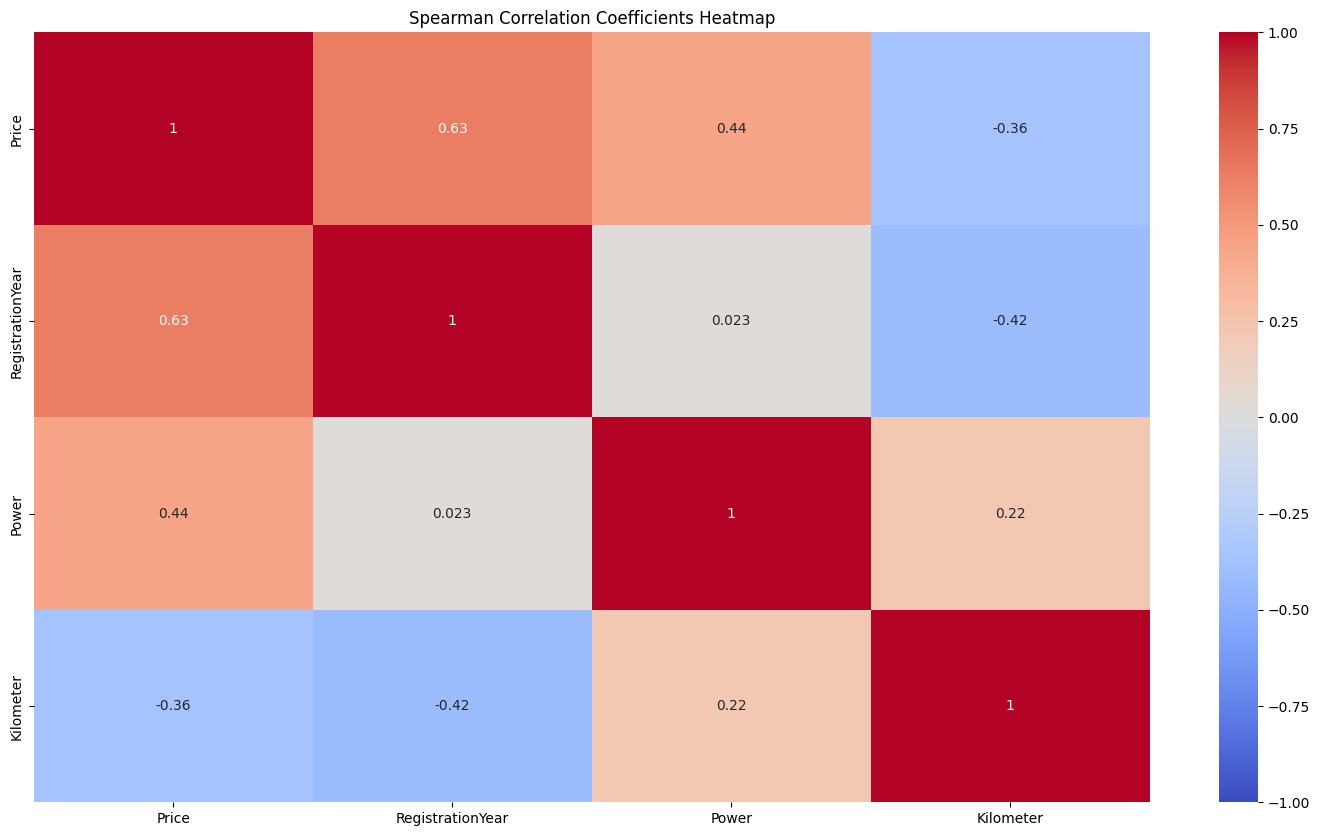

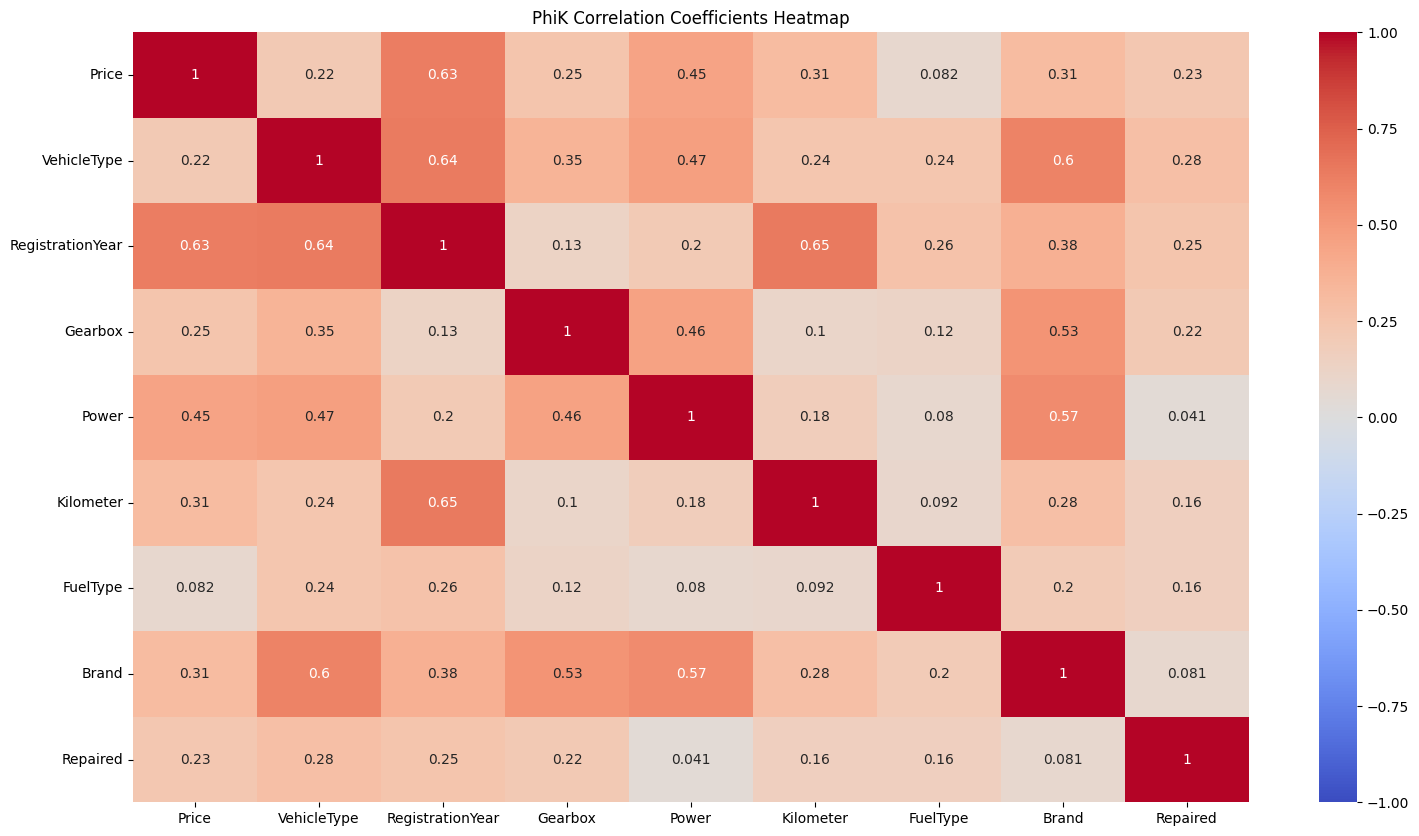

In [24]:
df = df.drop('Model', axis = 1)
df = df.drop_duplicates()
plt.figure(figsize=(18, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr('spearman'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlation Coefficients Heatmap')
plt.show()

phik_corr = phik_matrix(df, interval_cols=interval_cols)
plt.figure(figsize=(18, 10))
sns.heatmap(phik_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('PhiK Correlation Coefficients Heatmap')
plt.show()

In [25]:
# Общая информация об очищенном датасете

display(df.describe())
display(df.info())


,Price,RegistrationYear,Power,Kilometer
count,202024.000000,202024.000000,202024.000000,202024.000000
mean,6022.555988,2003.958797,129.695492,124047.365660
std,4638.140937,6.426691,54.617837,38754.223168
min,1001.000000,1931.000000,31.000000,5000.000000
25%,2350.000000,2001.000000,90.000000,100000.000000
50%,4499.000000,2005.000000,120.000000,150000.000000
75%,8499.000000,2008.000000,156.000000,150000.000000
max,20000.000000,2016.000000,544.000000,150000.000000


<class 'pandas.core.frame.DataFrame'>
Index: 202024 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             202024 non-null  int64 
 1   VehicleType       202024 non-null  object
 2   RegistrationYear  202024 non-null  int64 
 3   Gearbox           202024 non-null  object
 4   Power             202024 non-null  int64 
 5   Kilometer         202024 non-null  int64 
 6   FuelType          202024 non-null  object
 7   Brand             202024 non-null  object
 8   Repaired          202024 non-null  object
dtypes: int64(4), object(5)
memory usage: 15.4+ MB


None

Price анализ


count    202024.000000
mean       6022.555988
std        4638.140937
min        1001.000000
25%        2350.000000
50%        4499.000000
75%        8499.000000
max       20000.000000
Name: Price, dtype: float64

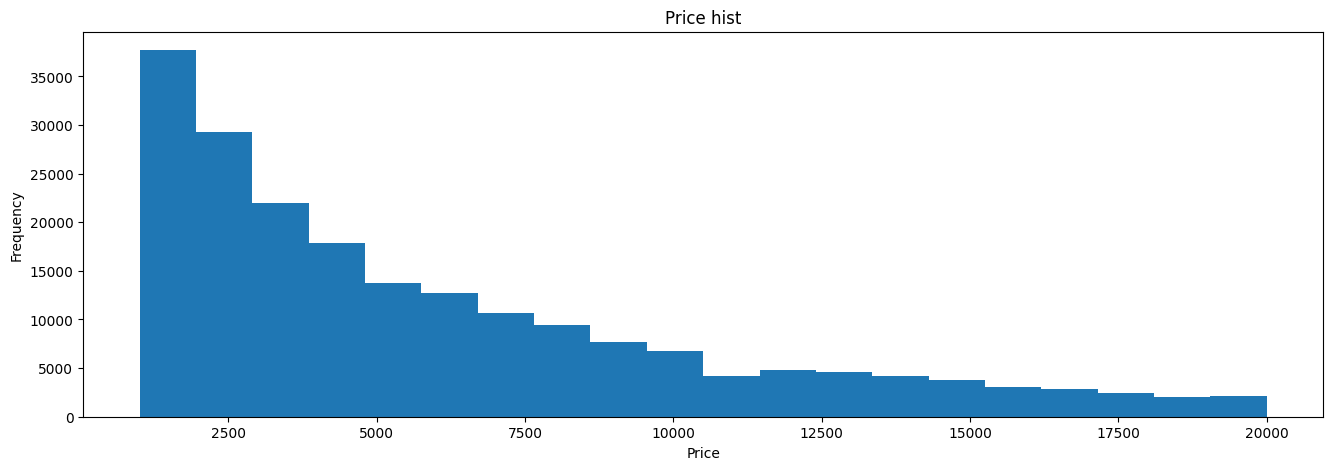

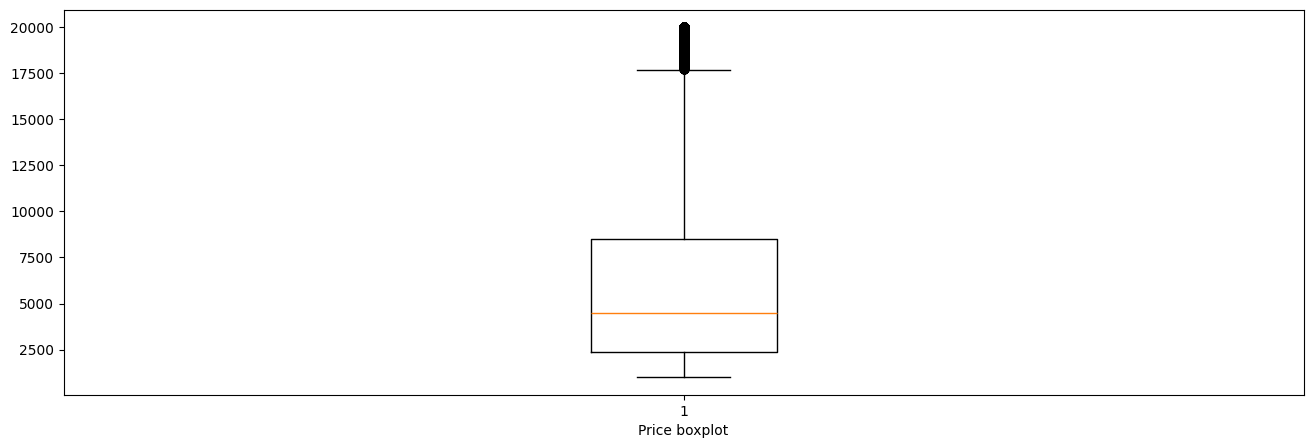

RegistrationYear анализ


count    202024.000000
mean       2003.958797
std           6.426691
min        1931.000000
25%        2001.000000
50%        2005.000000
75%        2008.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

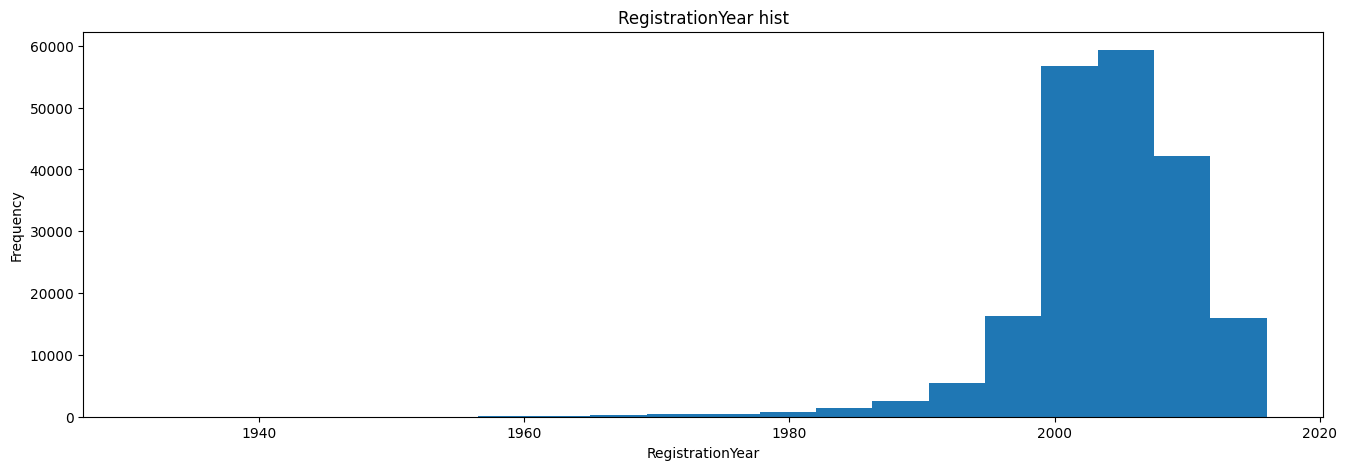

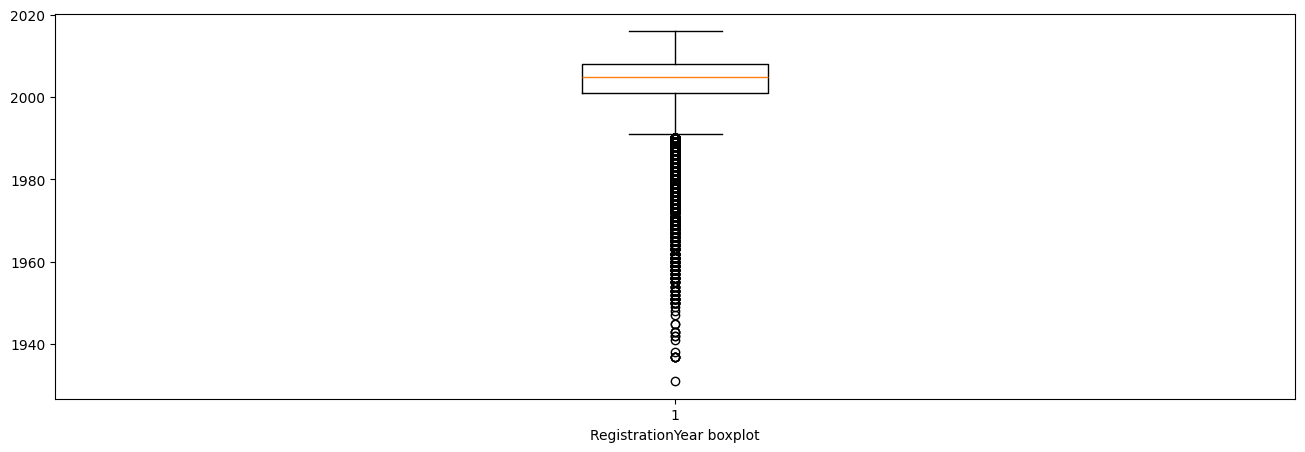

Power анализ


count    202024.000000
mean        129.695492
std          54.617837
min          31.000000
25%          90.000000
50%         120.000000
75%         156.000000
max         544.000000
Name: Power, dtype: float64

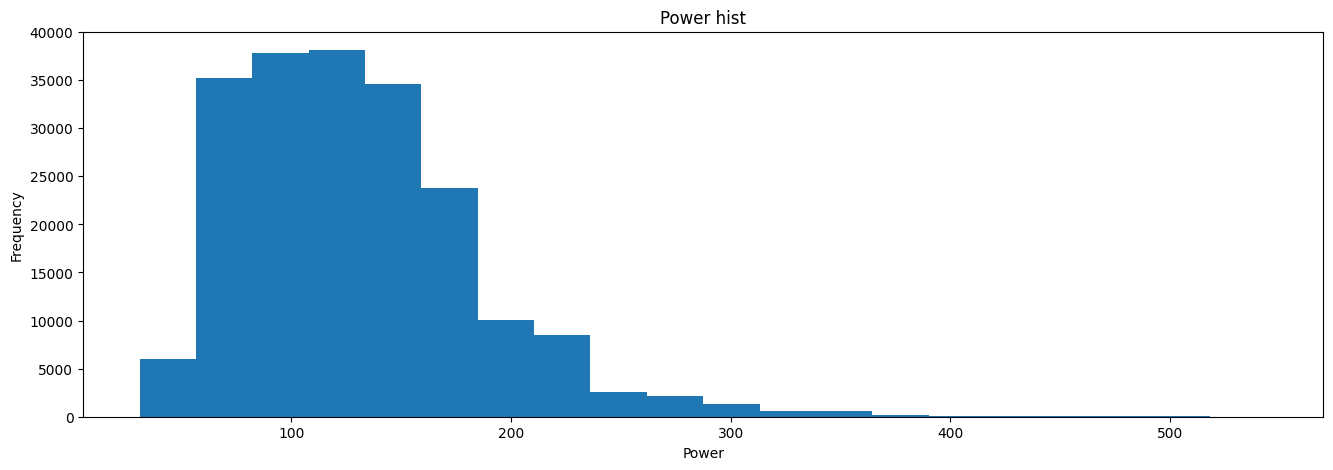

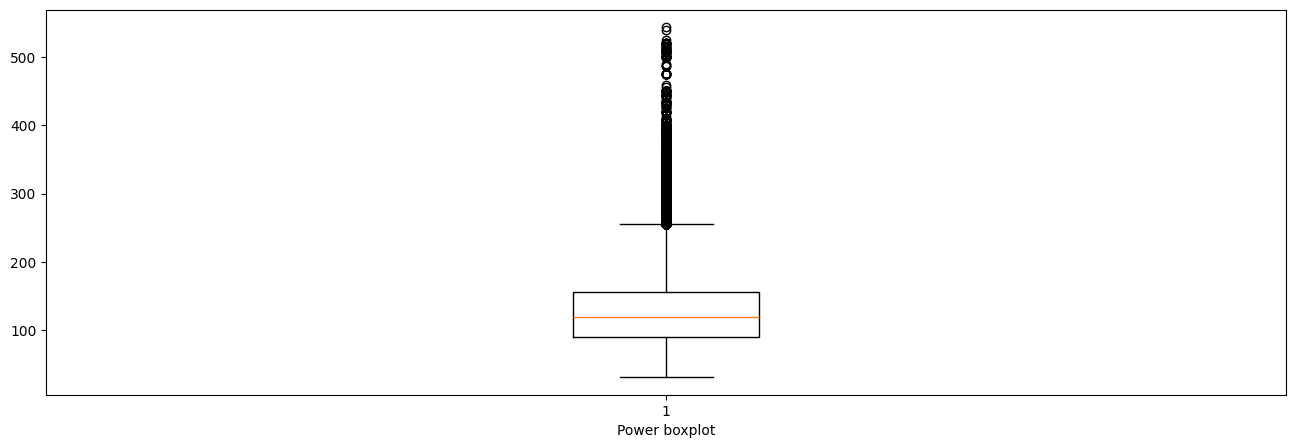

Kilometer анализ


count    202024.000000
mean     124047.365660
std       38754.223168
min        5000.000000
25%      100000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

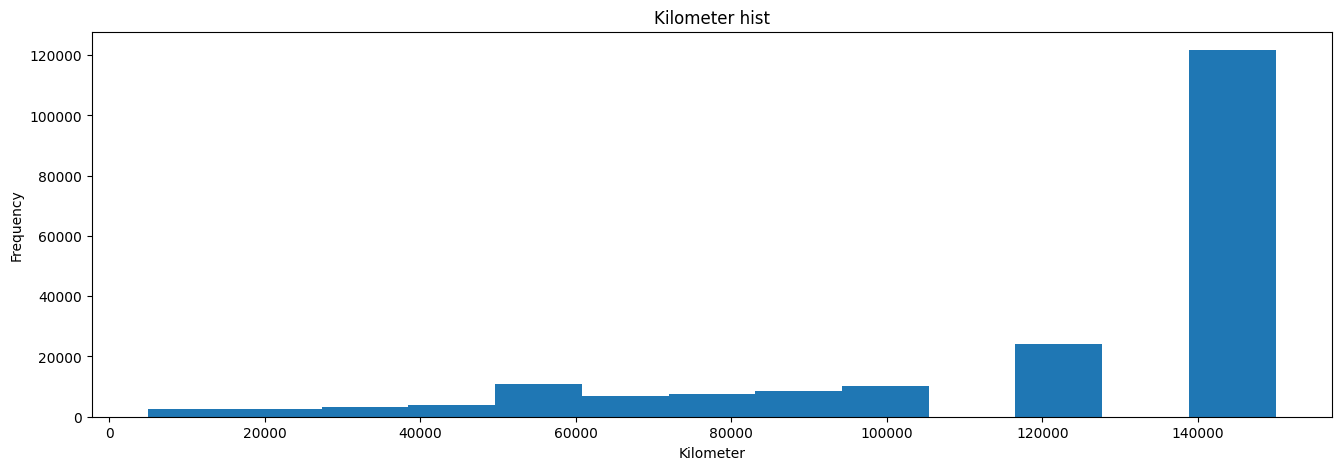

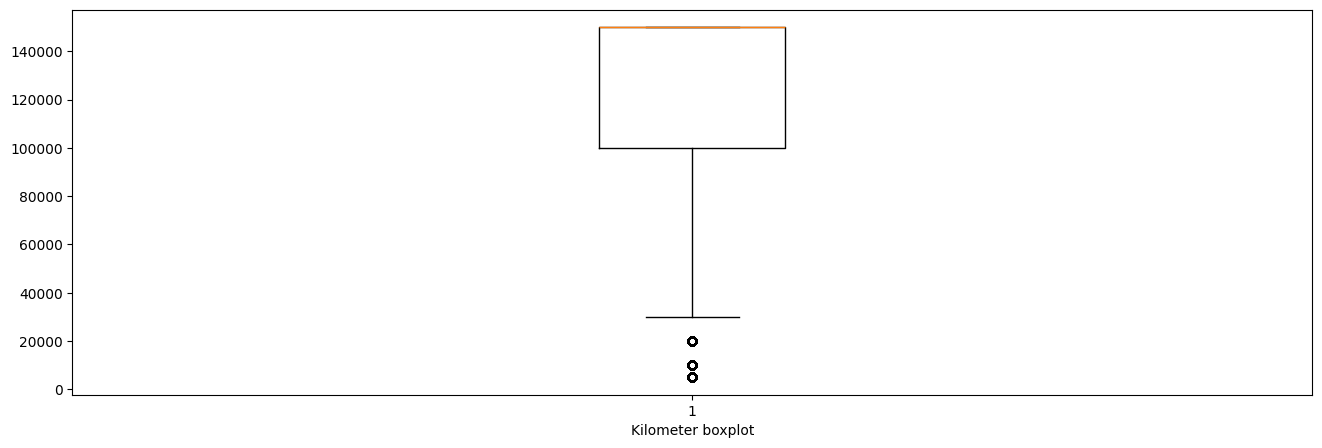

In [26]:
histplotter(df)

### Выводы
Были проанализированы данные: удалены полные дубликаты, удалены пропуски, удалены аномалии. Удалены неинформативные с точки зрения общей логики столбцы: DateCreated, DateCrawled, LastSeen, PostalCode, ResigrationMonth.
Проведен корреляционный анализ, удален один из входных признаков (Model) с высокой корреляцией с другими входными признаками.

## Обучение моделей

### Подготовка данных и создание трансформеров

In [27]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']
num_features = ['RegistrationYear', 'Power', 'Kilometer']

In [28]:
X = df[num_features + cat_features]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
])

### CatBoostRegressor модель

In [30]:

catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(loss_function='RMSE', verbose=False, iterations = 500))
])

param_grid_cb = {
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__l2_leaf_reg': [1, 5]
}

grid_search_cb = GridSearchCV(catboost_pipeline, param_grid_cb, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_cb.fit(X_train, y_train)
best_params_cb = grid_search_cb.best_params_
best_model_cb = grid_search_cb.best_estimator_
print("Best Hyperparameters CatBoostRegressor:", best_params_cb)
print("Best CatBoostRegressor model RMSE:", np.sqrt(-grid_search_cb.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters CatBoostRegressor: {'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
Best CatBoostRegressor model RMSE: 1787.693891637241


In [31]:
# Замер времени обучения лучшей модели

start_time = time.time()
best_model_cb.fit(X_train, y_train)
training_time_cb = time.time() - start_time

# Замер времени предсказания лучшей модели

start_time = time.time()
y_pred_cb = best_model_cb.predict(X_train)
prediction_time_cb = time.time() - start_time

print('CatBoostRegressor model training time, s:', training_time_cb)
print('CatBoostRegressor model prediction time, s:', prediction_time_cb)

CatBoostRegressor model training time, s: 2.6964240074157715
CatBoostRegressor model prediction time, s: 0.1719040870666504


### Результаты CatBoost

/Users/NOrlov/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


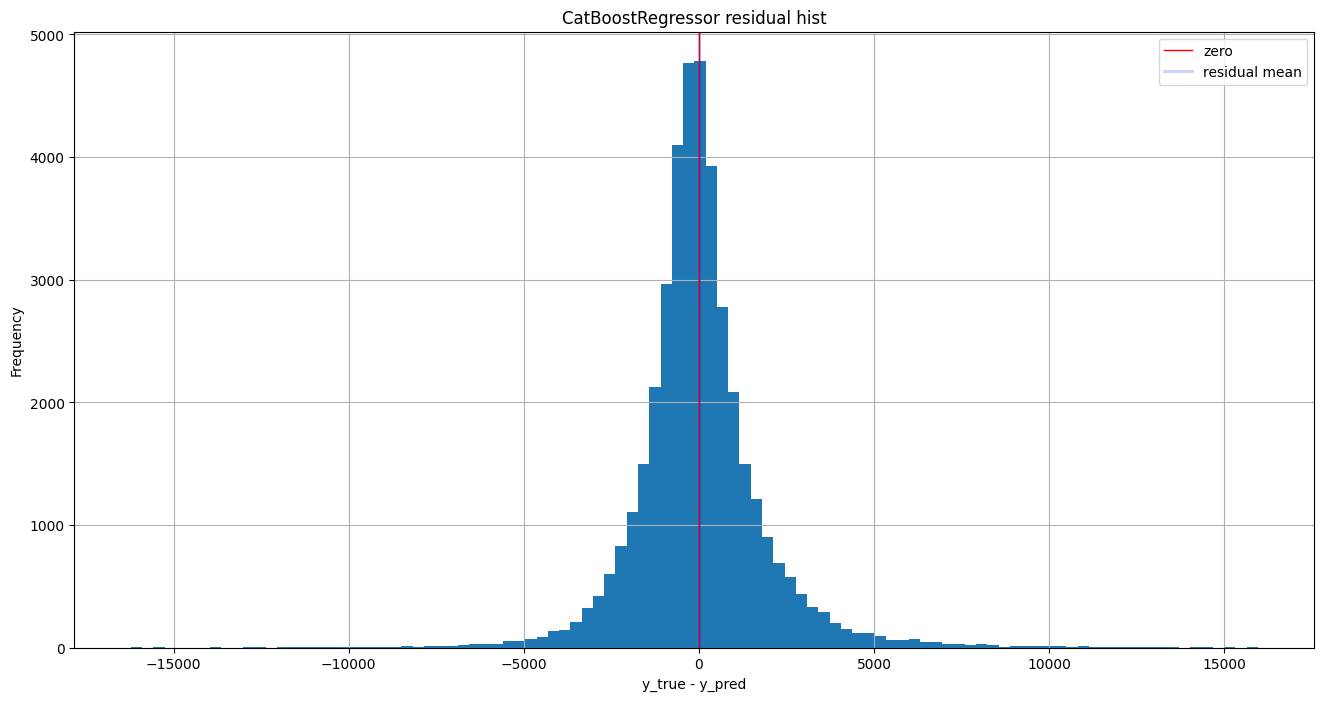

Best Hyperparameters CatBoostRegressor: {'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
Root Mean Squared Error CatBoostRegressor: 1796.7918299705555
Training Time CatBoostRegressor: 2.6964240074157715 seconds
Prediction Time CatBoostRegressor: 0.1719040870666504 seconds


In [32]:
y_pred_cb = best_model_cb.predict(X_test)
rmse_cb = mean_squared_error(y_test, y_pred_cb, squared=False)

plt.figure(figsize = (16,8))
plt.hist(y_test - y_pred_cb, bins=100)
plt.xlabel('y_true - y_pred')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='-', linewidth=1, label = 'zero')
plt.axvline(x=np.mean(y_test - y_pred_cb), color='b', linestyle='-', linewidth=2, alpha = 0.2, label = 'residual mean')
plt.legend()
plt.title('CatBoostRegressor residual hist')
plt.grid('true')
plt.show();

print("Best Hyperparameters CatBoostRegressor:", best_params_cb)
print("Root Mean Squared Error CatBoostRegressor:", rmse_cb)
print("Training Time CatBoostRegressor:", training_time_cb, "seconds")
print("Prediction Time CatBoostRegressor:", prediction_time_cb, "seconds")

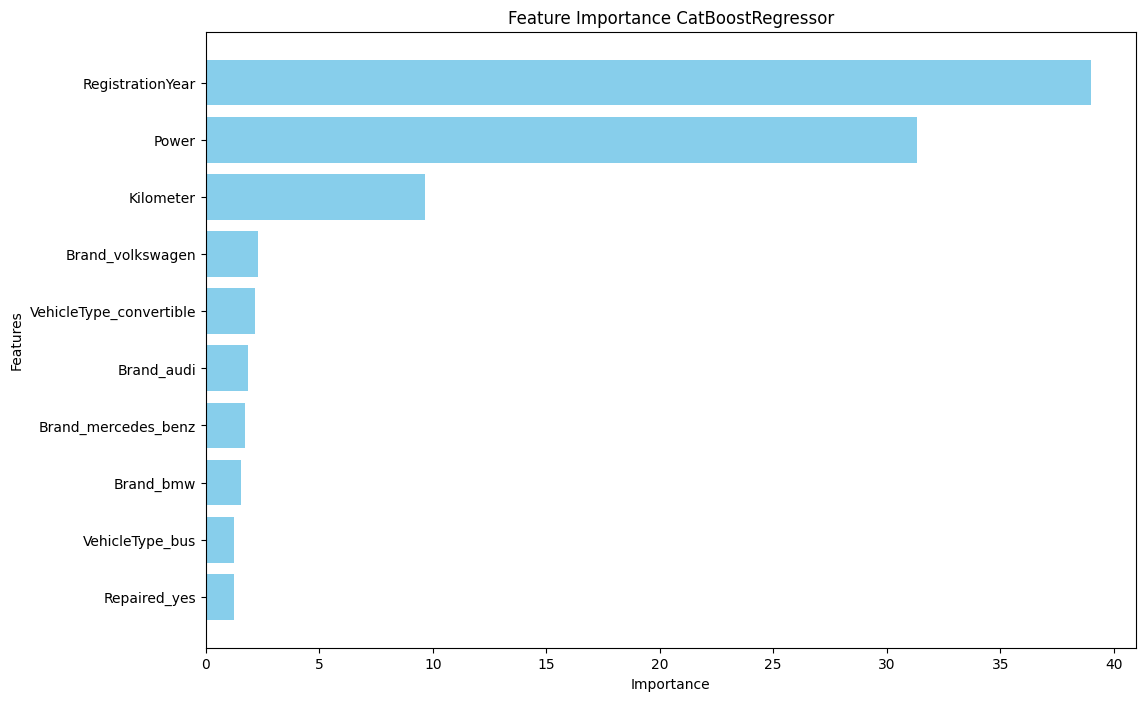

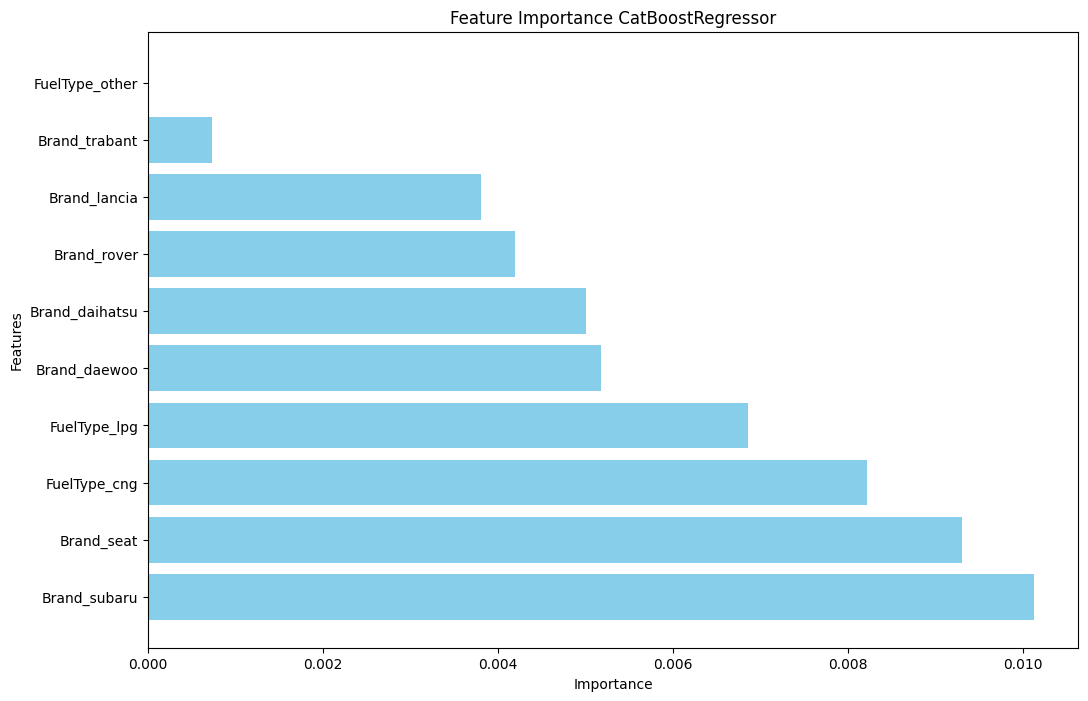

In [33]:
# Определение важности признаков CatBoostRegressor

best_model = grid_search_cb.best_estimator_
preprocessor = best_model.named_steps['preprocessor']
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
encoded_categorical_names = onehot_encoder.get_feature_names_out(input_features=cat_features)
all_feature_names = num_features + list(encoded_categorical_names)
catboost_regressor = best_model.named_steps['catboost']
feature_importances = catboost_regressor.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Максимальные признаки

feature_importance_df_max = feature_importance_df.sort_values(
    by='Importance', ascending=False
).head(10)
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_max['Feature'], feature_importance_df_max['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance CatBoostRegressor')
plt.gca().invert_yaxis()
plt.show()

# Минимальные признаки

feature_importance_df_min = feature_importance_df.sort_values(
    by='Importance', ascending=True
).head(10)
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_min['Feature'], feature_importance_df_min['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance CatBoostRegressor')
plt.gca().invert_yaxis()
plt.show()

В качестве переменных гиперпараметров были выбраны l2_leaf_reg и learning_rate - лучшие результаты получены при значениях гиперпараметров, приведенных выше.

Важность признаков выглядит логичной.

Модель CatBoostRegressor имеет симметричное нормальное одномодальное распределение ошибки со средним значением около нуля. Это говорит об адекватности работы модели и отсутствии переобучения или недообучения. RMSE, время обучения и время предсказания приведены выше.


###  LightGBM модель

In [34]:
params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'verbose': -1,
    'n_estimators' : 500
}

lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgb.LGBMRegressor(**params_lgb))
])

param_grid_lgb = {
    'lgbm__num_leaves': [20, 30],
    'lgbm__learning_rate': [0.01, 0.1]
}

grid_search_lgb = GridSearchCV(lgb_pipeline, param_grid_lgb, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search_lgb.fit(X_train, y_train)
best_params_lgb = grid_search_lgb.best_params_
best_model_lgb = grid_search_lgb.best_estimator_
print("Best Hyperparameters LightGBM:", best_params_lgb)
print("Best LightGBM model RMSE:", np.sqrt(-grid_search_lgb.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters LightGBM: {'lgbm__learning_rate': 0.1, 'lgbm__num_leaves': 30}
Best LightGBM model RMSE: 1755.3875511179936


In [35]:
# Замер времени обучения лучшей модели

start_time = time.time()
best_model_lgb.fit(X_train, y_train)
training_time_lgb = time.time() - start_time


# Замер времени предсказания лучшей модели

start_time = time.time()
y_pred_lgb = best_model_lgb.predict(X_train)
prediction_time_lgb = time.time() - start_time

print('LightGBM model training time, s:', training_time_lgb)
print('LightGBM model prediction time, s:', prediction_time_lgb)

LightGBM model training time, s: 2.336972713470459
LightGBM model prediction time, s: 0.7667341232299805


### Результаты с LightGBM моделью

/Users/NOrlov/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


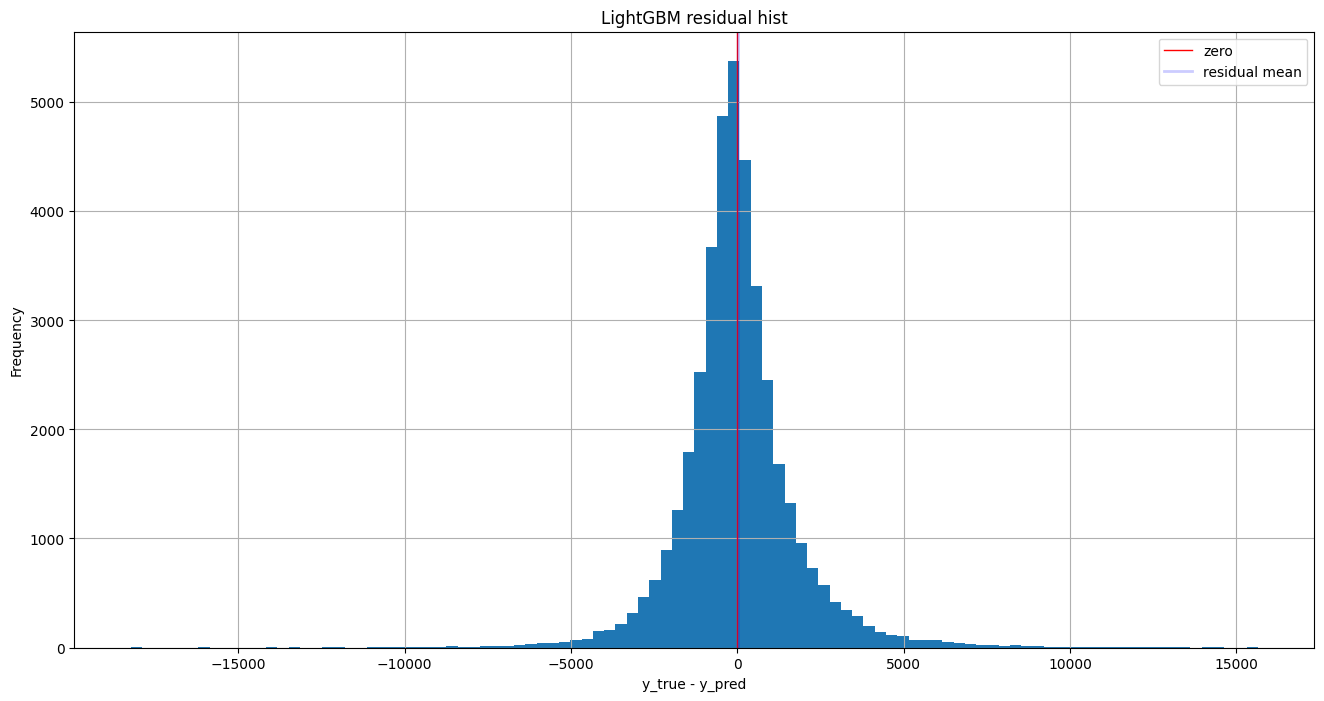

Best Hyperparameters LightGBM: {'lgbm__learning_rate': 0.1, 'lgbm__num_leaves': 30}
Root Mean Squared Error LightGBM: 1761.2695000353299
Training Time LightGBM: 2.336972713470459 seconds
Prediction Time LightGBM: 0.7667341232299805 seconds


In [36]:
y_pred_lgb = best_model_lgb.predict(X_test)
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)

plt.figure(figsize = (16,8))
plt.hist(y_test - y_pred_lgb, bins=100)
plt.xlabel('y_true - y_pred')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='-', linewidth=1, label = 'zero')
plt.axvline(x=np.mean(y_test - y_pred_lgb), color='b', linestyle='-', linewidth=2, alpha = 0.2, label = 'residual mean')
plt.legend()
plt.title('LightGBM residual hist')
plt.grid('true')
plt.show();

print("Best Hyperparameters LightGBM:", best_params_lgb)
print("Root Mean Squared Error LightGBM:", rmse_lgb)
print("Training Time LightGBM:", training_time_lgb, "seconds")
print("Prediction Time LightGBM:", prediction_time_lgb, "seconds")

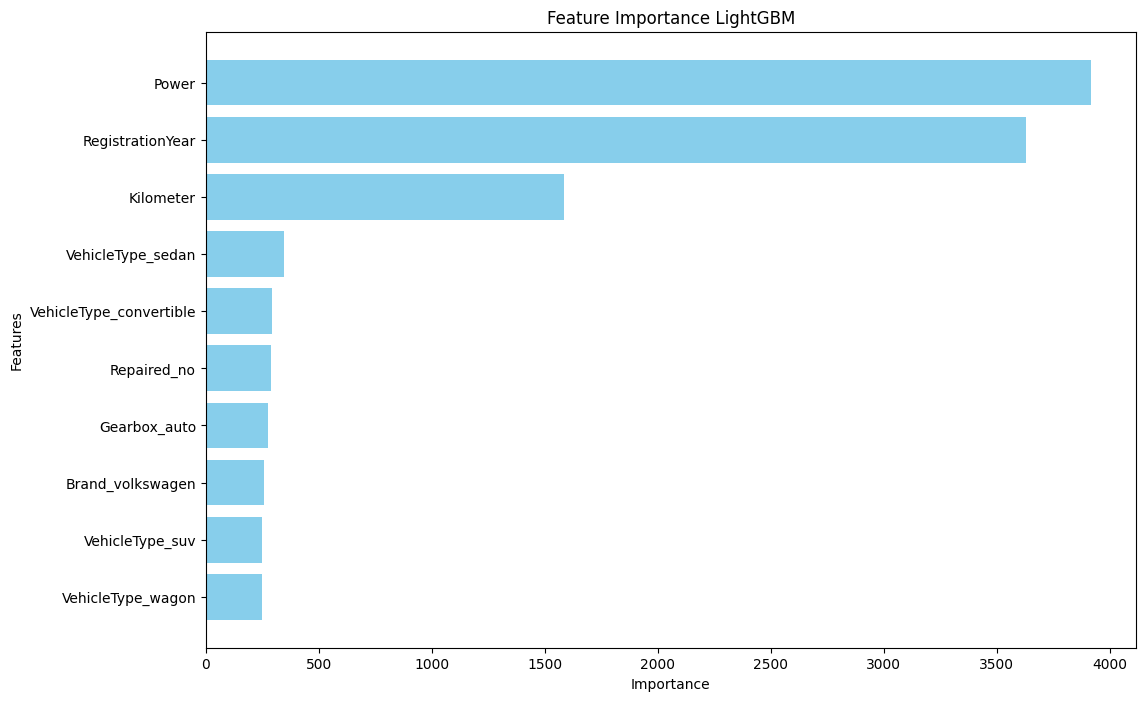

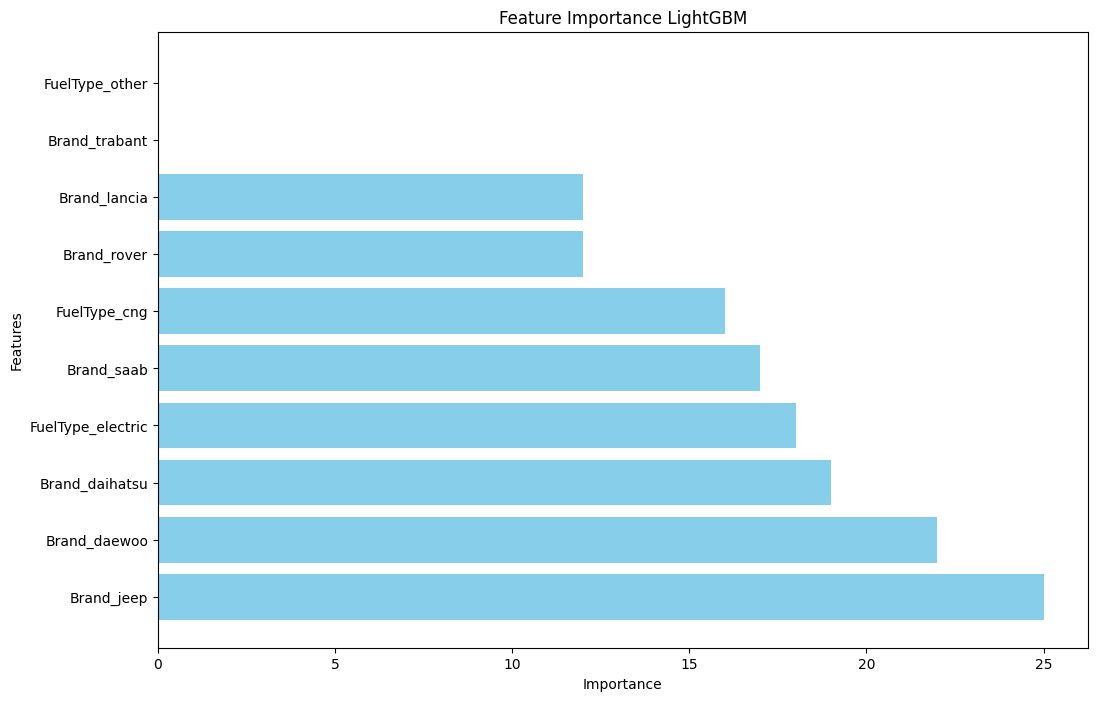

In [37]:
# Определение важности признаков LightGBM

best_model = grid_search_lgb.best_estimator_
preprocessor = best_model.named_steps['preprocessor']
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
encoded_categorical_names = onehot_encoder.get_feature_names_out(input_features=cat_features)
all_feature_names = num_features + list(encoded_categorical_names)
lgbm_regressor = best_model.named_steps['lgbm']
feature_importances = lgbm_regressor.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Максимальные признаки

feature_importance_df_max = feature_importance_df.sort_values(
    by='Importance', ascending=False
)[:10]
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_max['Feature'], feature_importance_df_max['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance LightGBM')
plt.gca().invert_yaxis()
plt.show()

# Минимальные признаки

feature_importance_df_min = feature_importance_df.sort_values(
    by='Importance', ascending=True
)[:10]
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df_min['Feature'], feature_importance_df_min['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance LightGBM')
plt.gca().invert_yaxis()
plt.show()

В качестве переменных гиперпараметров были выбраны num_leaves и learning_rate - лучшие результаты получены при значениях гиперпараметров, приведенных выше.

Важность признаков выглядит логичной.

Модель LightGBM имеет симметричное нормальное одномодальное распределение ошибки со средним значением около нуля. Это говорит об адекватности работы модели и отсутствии переобучения или недообучения. RMSE, время обучения и время предсказания приведены выше.

### LinearRegression модель

In [38]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear_regression', LinearRegression())
])

param_grid_lr = {}

In [39]:
grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_lr.fit(X_train, y_train)
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_
print("Best Hyperparameters LinearRegression:", best_params_lr)
print("Best LinearRegression model RMSE:", np.sqrt(-grid_search_lr.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters LinearRegression: {}
Best LinearRegression model RMSE: 2972.5807483796257


In [40]:
# Замер времени обучения лучшей модели

start_time = time.time()
best_model_lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time

# Замер времени предсказания лучшей модели

start_time = time.time()
y_pred_lr = best_model_lr.predict(X_train)
prediction_time_lr = time.time() - start_time

print('LinearRegression model training time, s:', training_time_lr)
print('LinearRegression model prediction time, s:', prediction_time_lr)

LinearRegression model training time, s: 0.35676002502441406
LinearRegression model prediction time, s: 0.12917304039001465


### Результаты с LinearRegression моделью

/Users/NOrlov/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


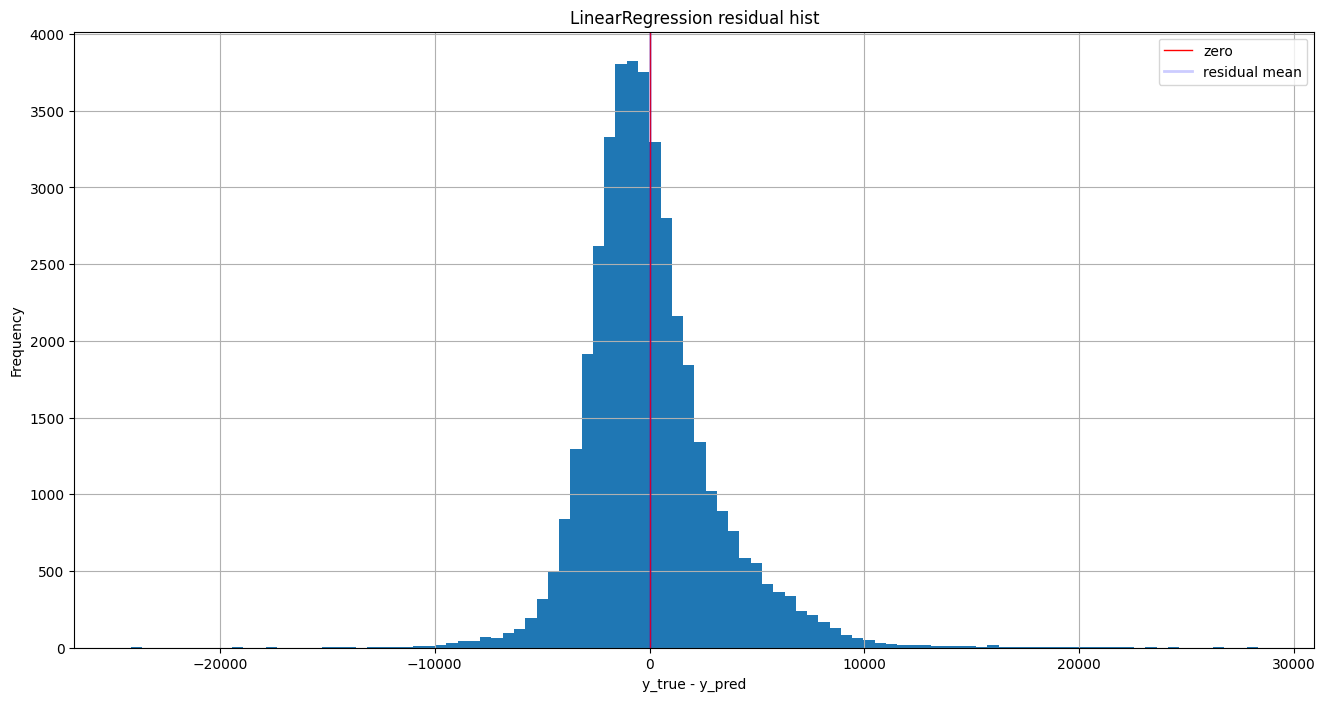

Best Hyperparameters LinearRegression: {}
Root Mean Squared Error LinearRegression: 2979.4834053868694
Training Time LinearRegression: 0.35676002502441406 seconds
Prediction Time LinearRegression: 0.12917304039001465 seconds


In [41]:
y_pred_lr = best_model_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

plt.figure(figsize = (16,8))
plt.hist(y_test - y_pred_lr, bins=100)
plt.xlabel('y_true - y_pred')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='-', linewidth=1, label = 'zero')
plt.axvline(x=np.mean(y_test - y_pred_lr), color='b', linestyle='-', linewidth=2, alpha = 0.2, label = 'residual mean')
plt.legend()
plt.title('LinearRegression residual hist')
plt.grid('true')
plt.show();

print("Best Hyperparameters LinearRegression:", best_params_lr)
print("Root Mean Squared Error LinearRegression:", rmse_lr)
print("Training Time LinearRegression:", training_time_lr, "seconds")
print("Prediction Time LinearRegression:", prediction_time_lr, "seconds")

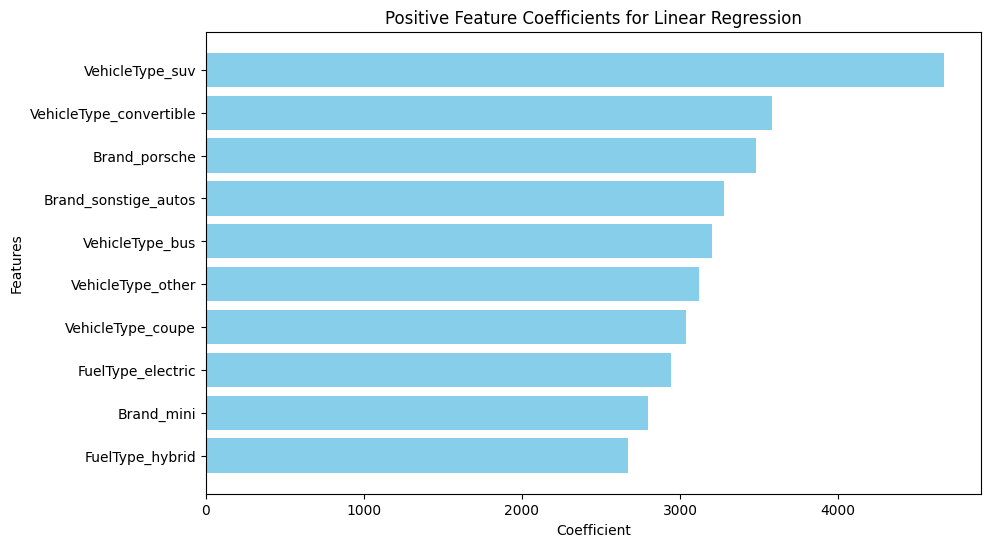

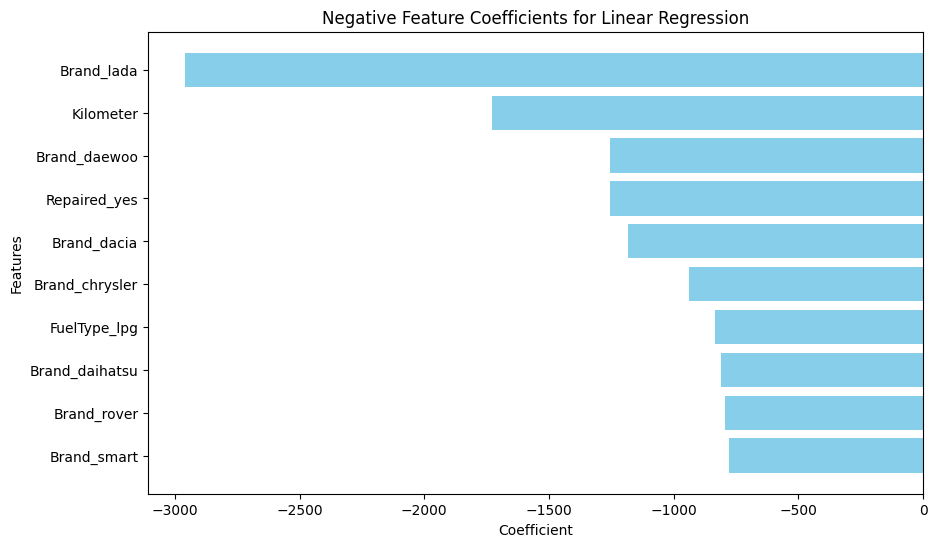

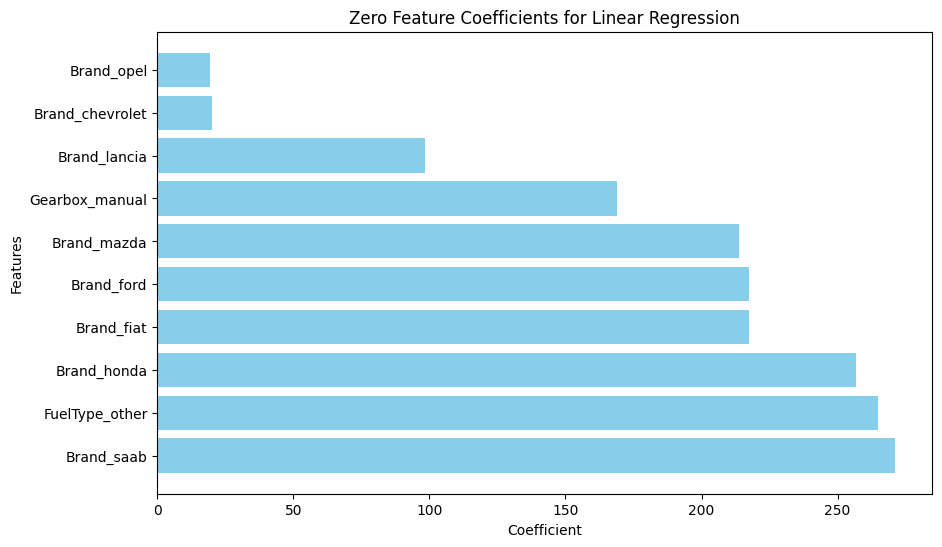

In [42]:
# Определение важности признаков LinearRegression

encoded_categorical_names = best_model_lr.named_steps['preprocessor'] \
    .named_transformers_['cat'].named_steps['onehot'] \
    .get_feature_names_out(input_features=cat_features)

all_feature_names = num_features + list(encoded_categorical_names)

linear_regressor = best_model_lr.named_steps['linear_regression']
coefficients = linear_regressor.coef_

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Максимальные положительные признаки

feature_importance_df_max = feature_importance_df.sort_values(
    by='Coefficient', ascending=False
)[:10]
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_max['Feature'], feature_importance_df_max['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Positive Feature Coefficients for Linear Regression')
plt.gca().invert_yaxis()
plt.show()

# Минимальные отрицательные признаки

feature_importance_df_min = feature_importance_df.sort_values(
    by='Coefficient', ascending=True
).head(10)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_min['Feature'], feature_importance_df_min['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Negative Feature Coefficients for Linear Regression')
plt.gca().invert_yaxis()
plt.show()

# Признаки с "нулевым" влиянием

feature_importance_df_zero = feature_importance_df
feature_importance_df_zero['Coefficient'] = abs(feature_importance_df_zero['Coefficient'])
feature_importance_df_zero = feature_importance_df_zero.sort_values(
    by='Coefficient', ascending=True
).head(10)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_zero['Feature'], feature_importance_df_zero['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Zero Feature Coefficients for Linear Regression')
plt.gca().invert_yaxis()
plt.show()

Несмотря на небольшую симметричность "хвостов" модель LinearRegression можно описать как нормальное одномодальное распределение ошибки со средним значением около нуля. Это говорит об адекватности работы модели и отсутствии переобучения или недообучения. RMSE, время обучения и время предсказания приведены выше.


## Анализ моделей

In [43]:
# Создадим "Dummy" модель

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))

print("RMSE для Dummy модели на тестовом наборе данных:", rmse_dummy)

RMSE для Dummy модели на тестовом наборе данных: 4668.0089286108105


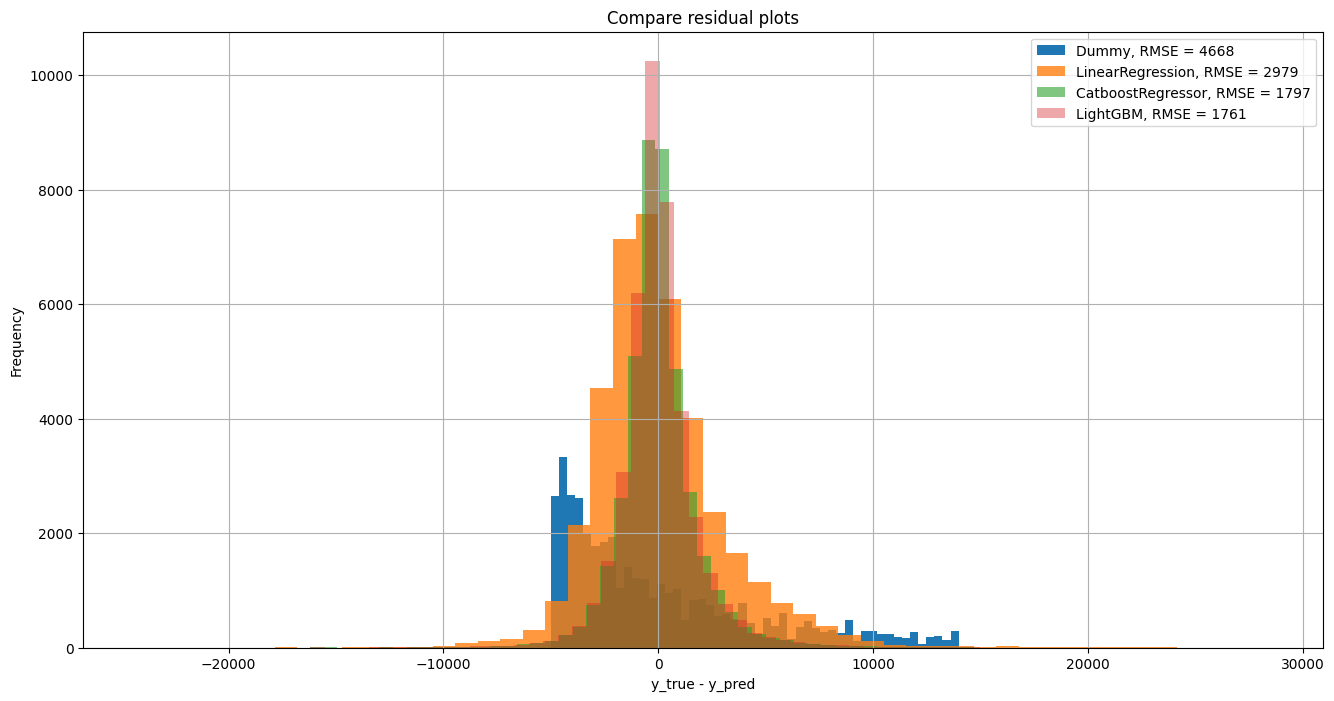

In [44]:
plt.figure(figsize = (16,8))
plt.hist(y_test - y_pred_dummy, bins=50, alpha = 1)
plt.hist(y_test - y_pred_lr, bins=50, alpha = 0.8)
plt.hist(y_test - y_pred_cb, bins=50, alpha = 0.6)
plt.hist(y_test - y_pred_lgb, bins=50, alpha = 0.4)
plt.legend(['Dummy, '+'RMSE = ' + str(round(rmse_dummy)),'LinearRegression, '+'RMSE = ' + str(round(rmse_lr)), 'CatboostRegressor, '+'RMSE = ' + str(round(rmse_cb)), 'LightGBM, '+'RMSE = ' + str(round(rmse_lgb))])
plt.ylabel('Frequency')
plt.xlabel('y_true - y_pred')
plt.title('Compare residual plots')
plt.grid('true')
plt.show();

In [45]:
CB_results = [rmse_cb, training_time_cb, prediction_time_cb]
LGB_results = [rmse_lgb, training_time_lgb, prediction_time_lgb]
LR_results = [rmse_lr, training_time_lr, prediction_time_lr]
Dummy_results = [rmse_dummy, np.nan, np.nan]

results_df = pd.DataFrame({'CatBoostRegressor': CB_results, 'LigthGBM' : LGB_results, 'LinearRegression' : LR_results, 'DummyResgressor' : Dummy_results})
results_df.index = ['RMSE', 'Training Time, s', 'Prediction Time, s']
results_df = round(results_df, 2)
results_df

,CatBoostRegressor,LigthGBM,LinearRegression,DummyResgressor
RMSE,1796.79,1761.27,2979.48,4668.01
"Training Time, s",2.70,2.34,0.36,NaN
"Prediction Time, s",0.17,0.77,0.13,NaN


### Выводы

Итого, наименьшую RMSE имеет LightGBM модель. Далее с небольшиим отрывом следует CatBoostRegressor. LinearRegression демонстрирует значимо худшую RMSE. Тем не менее, все модели показали лучшую rmse метрику, чем DummyRegressor.

Наименьшее время обучения и применения имеет LinearRegression модель. Далее следует CatBoostRegressor, затем LigthGBM.
Время прогнозирования у CatBoostRegressor и LinearRegression схоже, LightGBM требует на порядок большего времени.

Поскольку заказчика интересуют сразу все 3 параметра модели, CatBoostRegressor модель выглядит наиболее сбалансированной: ее RMSE лишь немного уступает LightGBM, при этом время обучения и время предсказания значимо меньше.

## Общий Вывод

Был изучен датасет объявлений о продаже автомобилей, содержащий технические характеристики и цены автомобилей.
Произведены предподготовка, очистка и статистический анализ данных: удалены пропуски и неинформативные данные.


С целью прогнозирования цены автомобиля были построены 3 модели с оптимизацией гиперпараметров, рассматривались CatBoosstRegressor, LightGBM, LinearRegression.


LightGBM и CatBoostRegression продемонстрировали допустимые RMSE метрики - обе менее требуемых 2500.
При этом в качестве оптимальной под цели заказчика по совокупности критериев (RMSE, время обучения и время прогнозирования) была выбрана модель CatBoostRegressor, которая имеет несколько худшую RMSE метрику и значимо лучшие время обучения и прогнозирования по сравнению с LightGBM.


